# Learning PageRank

### Overview

This Jupyter Notebook covers the **implementation of two types Graph Neural Networks** (GNN) that are able to learn and determine the PageRank value of a graph.

As such, the repository covers:
- A program to compute the PageRank value of a given graph
- A random graph generator based on Erdos' random graph and scale-free generation
- A GNN with relaxation
- A GNN with a convolutional graph approach

The python implementations are available in the `script` folder and will be imported in this notebook. 

#### Note & Citation

This notebook relies heavily on the `networkx` library:

> Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008

And the `torch_gnn` package:

> Matteo Tiezzi, Giuseppe Marra, Stefano Melacci, Marco Maggini and Marco Gori (2020). "A Lagrangian Approach to Information Propagation in Graph Neural Networks; ECAI2020

### Library imports

```sh
pip install dgl==0.6.1
pip install torch==1.9.1
```

In [1]:
import networkx as nx
import numpy as np
import torch

from scripts.dataset import concatenate_graph_dataset
from scripts.dataset import generate_graph_dataset
from scripts.dataset import load_concatenated_graph_dataset
from scripts.dataset import PageRankDataset
from scripts.functions import generate_erdos_graph
from scripts.functions import generate_scale_free_graph
from scripts.functions import plot_graph
from scripts.functions import override_torch_gnn_library
from scripts.graph_networks import PageRankModelingWithGNN
from scripts.page_rank import page_rank
from scripts.random_graph_generator import Random_Graph_Generator

%matplotlib inline

Using backend: pytorch


In [2]:
override_torch_gnn_library() # skip_download=False to download/override torch_gnn

In [3]:
from torch_gnn.regression_gnn_wrapper import PageRankModelingWithRelaxationGNN

## 1. Implementing a Custom PageRank Function

### 1.1. The Concept of PageRank

#### Overview

PageRank or $PR$ is an link analysis algorithm used by Google to rank web pages. 

Considering pages as node of a (web)graph, hyperlinks or references between pages are considered as edges of said graph. The PageRank of a node is the numerical weight representing the importance of the node in the graph, which is computed by the number of incoming link to the node existing within the graph itself. 

> Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.

#### Overview of the Algorithm

The PageRank algorithm is recursive as any PageRank value of a node of a graph is derived from the PageRank values of other nodes. 

<u>Initialization:</u>

Given a graph $G$ with nodes $\forall i\in\{0,1,\ldots,n\}, N_i\in G$. Edges corresponds to links between each nodes (no node self-references). Each node is initialized with a PageRank value drawn from a probability distribution with domain $[0,1]$ and summing to 1. 

A node $N_i$ transfers its PageRank value to the node $N_j$ it references (i.e. via an outbound link $N_i\rightarrow N_j$). The value transfer is done in equal proportion between each link $\forall j\in\{0,\ldots,n\},i\neq j, N_i\rightarrow N_j$. 

<u>Page Rank computation:</u>

As such, the PageRank amount granted to a node $N_j$ from a node $N_i$ via an outbound link $N_i\rightarrow N_j$ is:

$\forall i, j\in\{0,1,\ldots,n\},i\neq j,$
\begin{align}
N_i, N_j&\in G\\
PR_{\text{transferred},\,N_i\rightarrow N_j}(N_i)&=\frac{PR(N_i)}{L(N_i)}\\
L(N_i)&=\overset{n}{\underset{i=0\\i\neq j}{\sum}}\mathbb{1}_{\exists N_i\rightarrow N_j}
\end{align}

Consequently, the PageRank value of a single node $N_i$ is:

$$\forall i, j\in\{0,1,\ldots,n\},i\neq j,\,PR(N_i)=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}PR_{\text{transferred},\,N_j\rightarrow N_i}(N_j)\big)$$

With $\mathcal{M}(i)$ the set of nodes $N_j$ that link to node $N_i$, $d$ a damping vactor (often set to $0.85$) that captures the idea that a random walker on the web will continue clicking on links on a page/node as a reducing rate.

#### Note on PageRank and Message Passing Models

We find some similarities between the way PageRank is computed and a generic model description of Graph Neural Networks based on message exchange among neighbors. Many GNN models can be described using this formalism called *Message Passing*, which helps understand how information propagates within a graph.

<center><img src="assets/message_passing.gif" width="400"></center>

### 1.2. Iterative Implementation

We decide to implement PageRank's iterative method described as such:

#### Initialization

- $n$, the number of nodes in the graph
- $t=0$, the starting timestep
- $\forall i\in\{0, \ldots, n\},\,PR(N_i; t=0)=\frac{1}{n}$, the starting PageRank of a node $N_i$ at time $t=0$
- $d\in[0, 1]$, the damping factor (usually set to $0.85$)
- $\epsilon$, an error parameter used to stop the algorithm

#### Iterative Steps

At each time step,

\begin{align}
\forall i\in\{0, \ldots, n\},\,PR(N_i; t+1)&=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}\frac{PR(N_j)}{L(N_j)}\big)\\
\end{align}

We denote $R(t)$ the column vector of length $n$ which row values are $\forall i \in \{0, \ldots, n\}, PR(N_i; t)$.

#### Iteration Stop

The above iterative process stops when: $$|R(t+1)-R(t)|<\epsilon$$

This assumes that the process has converged.

#### Example implementation

The full code is avalaible in the file `scripts/page_rank.py`.

In [4]:
# Generates a probabilistic transition matrix M
# of a graph with 10 nodes
M = np.random.random(size=(10, 10))
N = np.random.randint(0, 2, size=(10, 10))
M = M*N # adds zeros
M = M/M.sum(axis=0) # sums columns to one

print("Transition matrix M:\n", np.round(M, 1))

Transition matrix M:
 [[0.  0.1 0.  0.  0.3 0.2 0.  0.  0.2 0.2]
 [0.1 0.3 0.1 0.2 0.  0.  0.  0.  0.3 0.2]
 [0.  0.3 0.1 0.2 0.4 0.  0.  0.  0.  0.3]
 [0.4 0.  0.1 0.1 0.1 0.  0.  0.  0.2 0.2]
 [0.3 0.  0.1 0.3 0.  0.  0.  0.  0.  0.1]
 [0.2 0.  0.1 0.  0.1 0.3 0.2 0.  0.  0. ]
 [0.  0.2 0.  0.1 0.  0.  0.2 1.  0.  0. ]
 [0.  0.  0.1 0.  0.  0.2 0.3 0.  0.  0. ]
 [0.  0.  0.2 0.  0.  0.  0.3 0.  0.3 0. ]
 [0.  0.  0.1 0.1 0.2 0.3 0.  0.  0.  0. ]]


In [5]:
# Computes the PageRank of each of the 10 nodes
page_rank(M, print_convergence=True)

PageRank converged at iteration 13 with epsilon=1e-05.


array([[0.0961422 ],
       [0.11385271],
       [0.11975647],
       [0.09810491],
       [0.07669073],
       [0.09120243],
       [0.15469917],
       [0.08008087],
       [0.09740024],
       [0.07207027]])

## 2. Generating Random Graphs

### 2.1. Generating an Example Erdos Graph

In [6]:
g = generate_erdos_graph(10, 0.3)

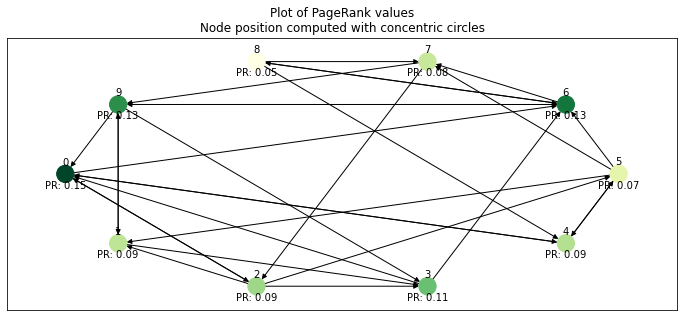

In [7]:
plot_graph(g, layout="shell")

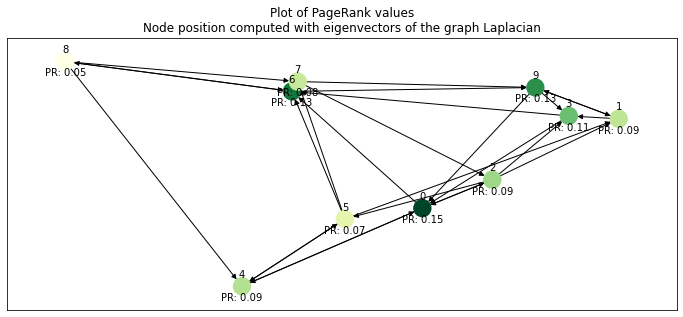

In [8]:
plot_graph(g, layout="spectral")

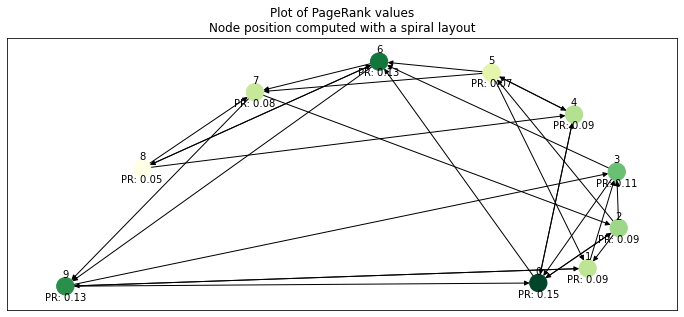

In [9]:
plot_graph(g, layout="spiral")

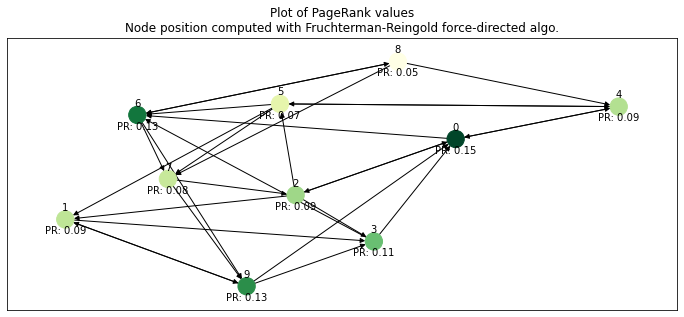

In [10]:
plot_graph(g, layout="spring")

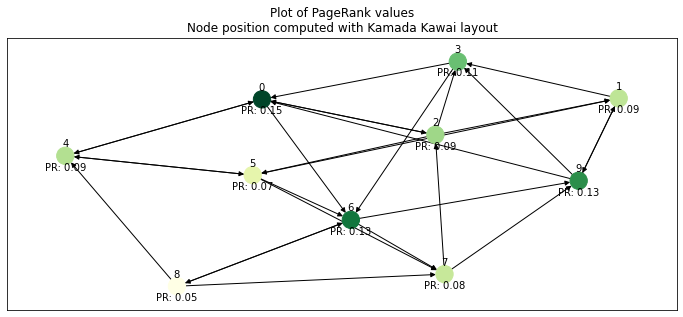

In [11]:
plot_graph(g, layout="kamada kawai")

### 2.2. Generating an Example Scale-Free Graph

In [12]:
g = generate_scale_free_graph(10)

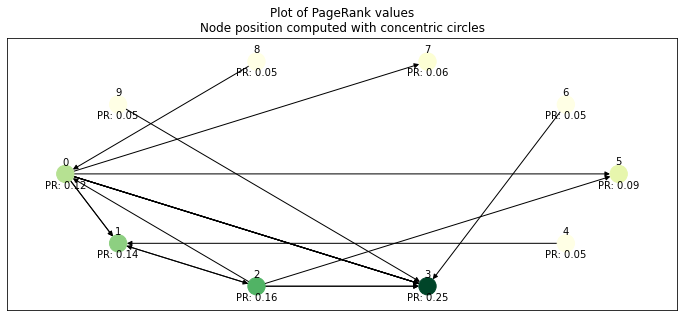

In [13]:
plot_graph(g, layout="shell")

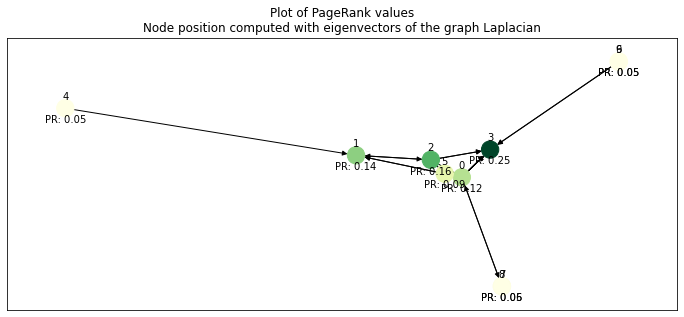

In [14]:
plot_graph(g, layout="spectral")

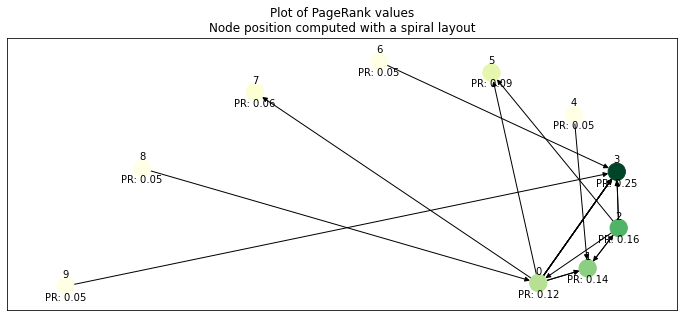

In [15]:
plot_graph(g, layout="spiral")

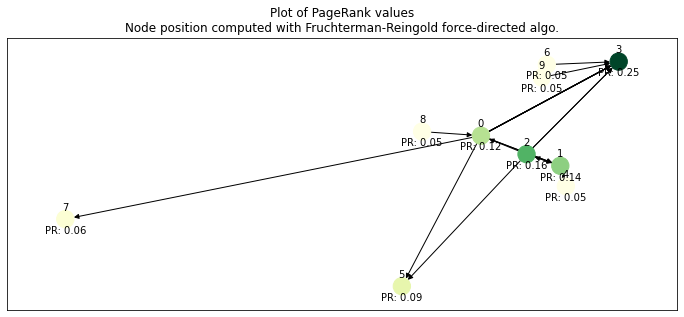

In [16]:
plot_graph(g, layout="spring")

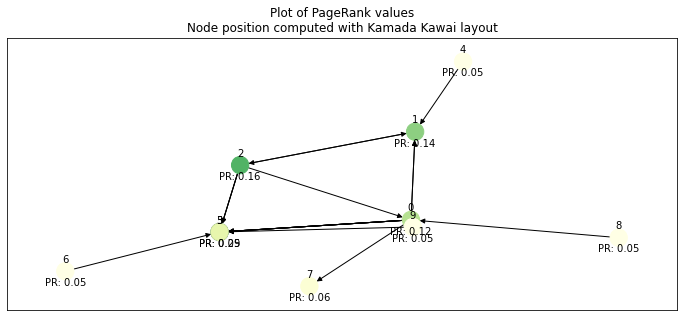

In [17]:
plot_graph(g, layout="kamada kawai")

### 2.2. Many Graphs Generation

#### Erdos' Method

The Erdős-Rényi graph or a binomial graph is a graph model that construct a graph $G_{n,p}$ where each of the possible edges between $n$ nodes appear with a fixed probability $p$. Each edge's probability of appearance is independent from the other edge's own probabilities.

> P. Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).

<u>Example</u>

In [18]:
erdos_generator = Random_Graph_Generator("erdos", True)
erdos_generator.graphs_generate(100, 5, 0.5)
erdos_generator.graphs_page_rank_compute()
eX, ey = erdos_generator.graphs_retrieve()

Erdos Graph Generator declared
5 graphs were generated
PageRank values computed


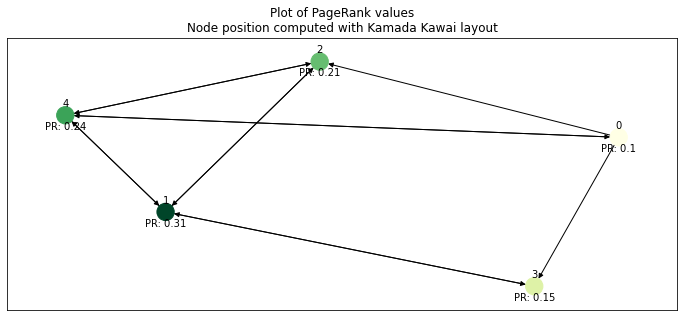

{0: 0.09671812299128124,
 1: 0.3103913514530068,
 2: 0.21206628321257667,
 3: 0.14534816022129543,
 4: 0.23547608212183965}

In [19]:
plot_graph(eX[50])
ey[50]

#### Scale-Free Method

The Scale-Free graph is a graph model that construct a graph $G_{n}$ of $n$ nodes with the property that the number of links $k$ originating from a given node exhibits a power law distribution $P(k)\sim k^(-\gamma)$. 

A scale-free network can be constructed by progressively adding nodes to an existing network and introducing links to existing nodes with preferential attachment so that the probability of linking to a given node $i$ is proportional to the number of existing links $k_i$ that node has such that:

$$P(\text{linking to node }i)\sim\frac{k_i}{\sum_jk_j}$$

> B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132--139, 2003.

<u>Example</u>

In [20]:
scalefree_generator = Random_Graph_Generator("scale-free", True)
scalefree_generator.graphs_generate(100, 5)
scalefree_generator.graphs_page_rank_compute()
sfX, sfy = scalefree_generator.graphs_retrieve()

Scale-Free Graph Generator declared
5 graphs were generated
PageRank values computed


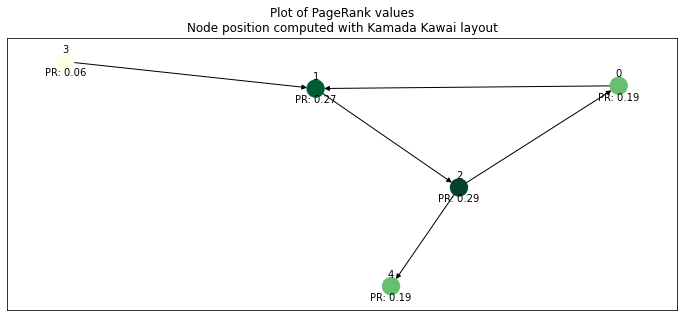

{0: 0.18630724092278833,
 1: 0.2724554091607107,
 2: 0.29325774231786467,
 3: 0.061672366675848175,
 4: 0.18630724092278833}

In [21]:
plot_graph(sfX[50])
sfy[50]

## 3. Learning PageRank

### 3.1. Building a Dataset
    
<u>Parameter selection</u>

To construct a dataset, we select:

- A **range of nodes $N$** to modulate the number of nodes in the graphs we want to create
- A selection of **graph-generating methods**. In our case: 
    - Erdos' method
    - Scale-Free method
- A **range of parameter values** for each parameter used to generate the graphs. In our case:
    - A range of probabilities $P$ to generate Erdos graphs
- A **number of graphs** to generate $n_{method}$ ***per given case and method***. In our case:
    - Erdos' method: we will obtain $n_{\text{erdos}}*len(P)*len(N)$
    - Scale-Free method: we will obtain $n_{\text{scale-free}}*len(N)$

As such, we choose to generate two graphs with either Erdos and Scale-Free graphs:

| Parameters | Description | Value | 
| :---: | :---: | :---: |
| P | Range of probabilities to generate Erdos graphs | {0.6} |
| N |  Range of nodes to generate graphs |  {60} |
| $n_{\text{erdos}}$ | Number of Erdos graphs to generate per case | 1 | 
| $n_{\text{scale-free}}$ | Number of Scale-Free graphs to generate per case | 2 |


In [22]:
# Declares the parameters

P            = [0.2]
N            = [15]
n_erdos      = 1
n_scale_free = 1

<u>Building the dataset</u>

We build 8 singular graphs each with a PageRank value per node, resulting in c. 70 nodes and 120 edges.

In [23]:
X, y = generate_graph_dataset(P, N, n_erdos, n_scale_free)

Generating Erdos graphs with parameters:
	Completed -- n=15, p=0.2

Generating Scale-Free graphs with parameter:
	Completed -- n=15


<u>Merging all graphs into a single entity and saving it</u>

We implement a function to concatenate all the generated graphs into a single large graph that can be used as input to a Graph Neural Network.

**Of note**, the cell is inactive on the assumption that it was already run and the result can be loaded using the load function located in the next cell.

In [24]:
pathX = "graph_files/graph_record02112022.graphml"
pathy = "graph_files/graph_record02112022_PageRanks.txt"

In [25]:
graphs, pageranks = concatenate_graph_dataset(X, y, pathX, pathy)

In [26]:
graphs, pageranks = load_concatenated_graph_dataset(pathX, pathy)

In [27]:
print(len(graphs.nodes), len(graphs.edges))

30 65


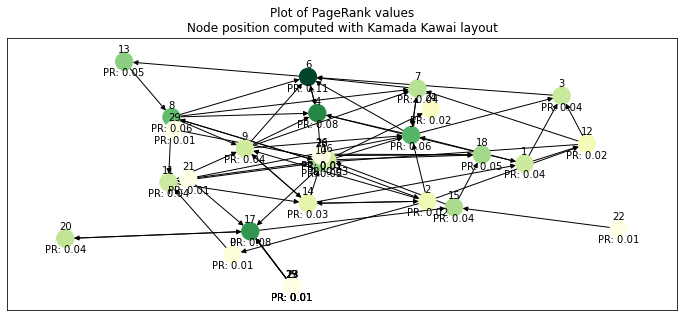

In [28]:
plot_graph(graphs)

<u>Building the DGL PageRank dataset</u>

In [29]:
dataset = PageRankDataset(graphs, pageranks, use_noise=True)
graph_noise_as_features = dataset[0]

dataset = PageRankDataset(graphs, pageranks, use_noise=False)
graph_torcheye_as_features = dataset[0]

### 3.2. Building Two Graph Neural Networks

<u>GNN with relaxation:</u>

In [30]:
# Declares important variables
graph  = graph_noise_as_features
E      = np.column_stack(graph.edges())
N      = graph.nodes()
labels = graph.ndata["label"].numpy()
train_mask = graph.ndata["train_mask"].numpy()
val_mask   = graph.ndata["test_mask"].numpy()
test_mask  = graph.ndata["val_mask"].numpy()

In [31]:
GNNrelaxation_model_adam = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    print_description = True
)


The model is a GNN based on a diffusion mechanism and relaxation.
A graph is processed by a set of nodes linked according to the
graph adjacency matrix/list of edges. The model updates the nodes' 
states by using an algorithm that shares information between 
(adjacent) nodes until an equilibrium state is reached. 

The output of the model is computed locally at each node based
on the node state.

The diffusion mechanism is constrained to ensure that a unique stable
equilibrium exists.

See also: https://persagen.com/files/misc/scarselli2009graph.pdf

Executing on device:  cpu


In [32]:
GNNrelaxation_model_adamw = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "AdamW"
)

Executing on device:  cpu


In [33]:
GNNrelaxation_model_adamax = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "Adamax"
)

Executing on device:  cpu


In [34]:
GNNrelaxation_model_adadelta = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "Adadelta"
)

Executing on device:  cpu


In [35]:
GNNrelaxation_model_SGD = PageRankModelingWithRelaxationGNN(
    N, E, labels,
    train_mask, val_mask, test_mask,
    optimizer = "SGD"
)

Executing on device:  cpu


<u>Convolutional GNN models (graph with noise as feature):</u>

In [36]:
# Declares important variables
hidden_features = 5
epochs = 1000

In [37]:
GCN_model_adam_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    print_description = True
)


The model was declared with GraphConv layers (2) which were introduced in:
> Semi-Supervised Classification with Graph Convolutional Networks
> by T. N. Kipf, M. Welling
> https://arxiv.org/pdf/1706.02216.pdf

Graph convolution is defined as follows:

```
h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}rac{1}{c_{ji}}h_j^{(l)}W^{(l)})
```

Where:
    - `\mathcal{N}(i)` is the set of neighbors of node `i`
    - `c_{ji}` is the product of the square root of node degrees
       `c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|}`)
    - `\sigma` is an activation function.

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv



In [38]:
GCN_model_adamw_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "AdamW"
)

In [39]:
GCN_model_adamax_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adamax"
)

In [40]:
GCN_model_adadelta_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adadelta"
)

In [41]:
GCN_model_SGD_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "SGD"
)

In [42]:
SAGE_model_adam_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    print_description = True
)


The model was declared with GraphSAGE layers (2) which were introduced in:
> Inductive Representation Learning on Large Graphs
> by W.L. Hamiton, R. Ying, and J. Leskovec
> https://arxiv.org/pdf/1706.02216.pdf

The GraphSAGE Algorithm trains weight matrices instead of relying on 
embedding tables. It allows adding and removing nodes directly via the 
weight matrix. Nodes embeddings do not need to be recomputed.

```
egin{align}
    h_{\mathcal{N}(i)}^{(l+1)} &= 
        	ext{aggregate}
        \left(
            \{h_{j}^{l}, orall j \in \mathcal{N}(i) \}
ight) h_{i}^{(l+1)}
    \
    &= \sigma 
        \left(
            W \cdot \mathrm{concat} (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) 
ight) h_{i}^{(l+1)} \
    &= \mathrm{norm}(h_{i}^{l})
\end{align}
```

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv



In [43]:
SAGE_model_adamw_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "AdamW"
)

In [44]:
SAGE_model_adamax_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adamax"
)

In [45]:
SAGE_model_adadelta_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adadelta"
)

In [46]:
SAGE_model_SGD_noise = PageRankModelingWithGNN(
    graph_noise_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "SGD"
)

<u>Convolutional GNN models (graph with torcheye as feature):</u>

In [47]:
# Declares important variables
hidden_features = 5
epochs = 1000

In [48]:
GCN_model_adam_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    print_description = True
)


The model was declared with GraphConv layers (2) which were introduced in:
> Semi-Supervised Classification with Graph Convolutional Networks
> by T. N. Kipf, M. Welling
> https://arxiv.org/pdf/1706.02216.pdf

Graph convolution is defined as follows:

```
h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}rac{1}{c_{ji}}h_j^{(l)}W^{(l)})
```

Where:
    - `\mathcal{N}(i)` is the set of neighbors of node `i`
    - `c_{ji}` is the product of the square root of node degrees
       `c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|}`)
    - `\sigma` is an activation function.

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv



In [49]:
GCN_model_adamw_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "AdamW"
)

In [50]:
GCN_model_adamax_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adamax"
)

In [51]:
GCN_model_adadelta_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "Adadelta"
)

In [52]:
GCN_model_SGD_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "GCN",
    optimizer = "SGD"
)

In [53]:
SAGE_model_adam_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    print_description = True
)


The model was declared with GraphSAGE layers (2) which were introduced in:
> Inductive Representation Learning on Large Graphs
> by W.L. Hamiton, R. Ying, and J. Leskovec
> https://arxiv.org/pdf/1706.02216.pdf

The GraphSAGE Algorithm trains weight matrices instead of relying on 
embedding tables. It allows adding and removing nodes directly via the 
weight matrix. Nodes embeddings do not need to be recomputed.

```
egin{align}
    h_{\mathcal{N}(i)}^{(l+1)} &= 
        	ext{aggregate}
        \left(
            \{h_{j}^{l}, orall j \in \mathcal{N}(i) \}
ight) h_{i}^{(l+1)}
    \
    &= \sigma 
        \left(
            W \cdot \mathrm{concat} (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) 
ight) h_{i}^{(l+1)} \
    &= \mathrm{norm}(h_{i}^{l})
\end{align}
```

See also: https://docs.dgl.ai/api/python/nn.pytorch.html#sageconv



In [54]:
SAGE_model_adamw_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "AdamW"
)

In [55]:
SAGE_model_adamax_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adamax"
)

In [56]:
SAGE_model_adadelta_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "Adadelta"
)

In [57]:
SAGE_model_SGD_eye = PageRankModelingWithGNN(
    graph_torcheye_as_features, 
    hidden_features, 
    epochs, 
    "SAGE",
    optimizer = "SGD"
)

### 3.3. Training the Graph Neural Networks

<u>GNN with relaxation:</u>

Epoch -- 100
	Training -- Mean Loss: 0.0123, Iterations: 5
	Validation -- Mean Loss: 0.0064, Iterations: 5
Epoch -- 200
	Training -- Mean Loss: 0.0049, Iterations: 5
	Validation -- Mean Loss: 0.0011, Iterations: 5
Epoch -- 300
	Training -- Mean Loss: 0.0018, Iterations: 5
	Validation -- Mean Loss: 0.0002, Iterations: 5
Epoch -- 400
	Training -- Mean Loss: 0.001, Iterations: 6
	Validation -- Mean Loss: 0.0008, Iterations: 6
Epoch -- 500
	Training -- Mean Loss: 0.0006, Iterations: 6
	Validation -- Mean Loss: 0.0013, Iterations: 6
Epoch -- 600
	Training -- Mean Loss: 0.0003, Iterations: 6
	Validation -- Mean Loss: 0.0017, Iterations: 6
Epoch -- 700
	Training -- Mean Loss: 0.0002, Iterations: 7
	Validation -- Mean Loss: 0.0021, Iterations: 7
Epoch -- 800
	Training -- Mean Loss: 1e-04, Iterations: 6
	Validation -- Mean Loss: 0.0024, Iterations: 6
Epoch -- 900
	Training -- Mean Loss: 1e-04, Iterations: 6
	Validation -- Mean Loss: 0.0027, Iterations: 6
Epoch -- 1000
	Training -- Mean Loss: 0.

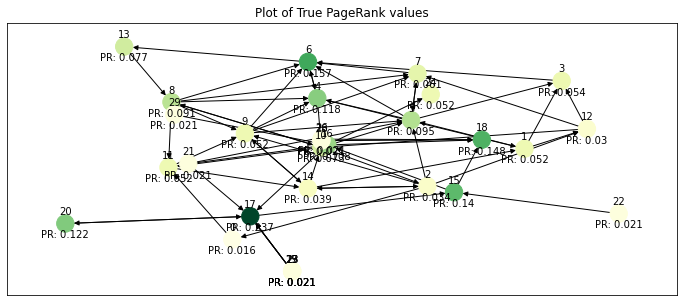

Plot with predicted labels
--------------------------


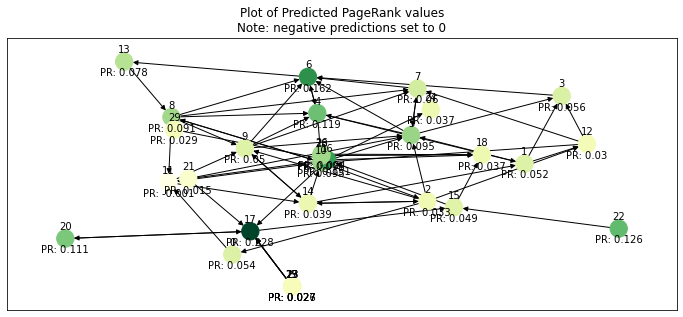

Ground Truth vs. Predictions
--------------------------


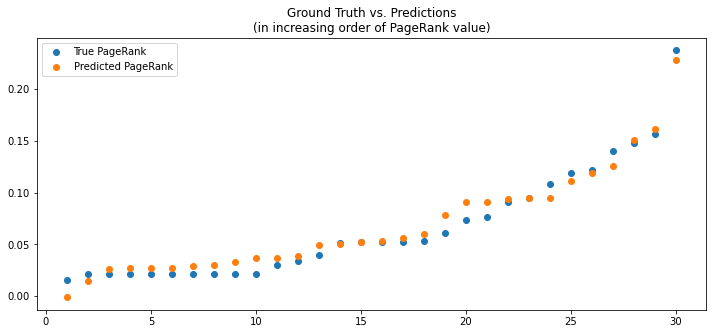

In [58]:
GNNrelaxation_model_adam.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.0057, Iterations: 8
	Validation -- Mean Loss: 0.0086, Iterations: 8
Epoch -- 200
	Training -- Mean Loss: 0.0014, Iterations: 50
	Validation -- Mean Loss: 0.0042, Iterations: 50
Epoch -- 300
	Training -- Mean Loss: 0.0008, Iterations: 50
	Validation -- Mean Loss: 0.0045, Iterations: 50
Epoch -- 400
	Training -- Mean Loss: 0.0006, Iterations: 45
	Validation -- Mean Loss: 0.0046, Iterations: 44
Epoch -- 500
	Training -- Mean Loss: 0.0004, Iterations: 18
	Validation -- Mean Loss: 0.0048, Iterations: 18
Epoch -- 600
	Training -- Mean Loss: 0.0002, Iterations: 9
	Validation -- Mean Loss: 0.005, Iterations: 9
Epoch -- 700
	Training -- Mean Loss: 1e-04, Iterations: 8
	Validation -- Mean Loss: 0.0052, Iterations: 8
Epoch -- 800
	Training -- Mean Loss: 1e-04, Iterations: 8
	Validation -- Mean Loss: 0.0055, Iterations: 8
Epoch -- 900
	Training -- Mean Loss: 0.0, Iterations: 8
	Validation -- Mean Loss: 0.0058, Iterations: 8
Epoch -- 1000
	Training -- Mean Los

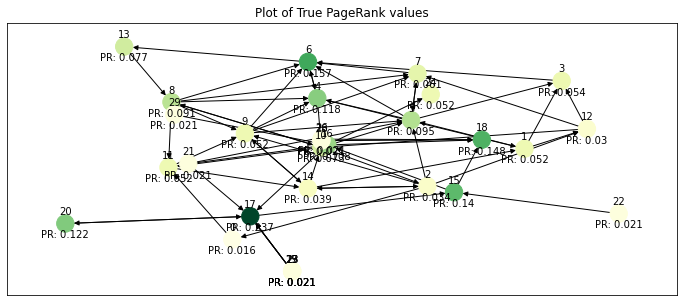

Plot with predicted labels
--------------------------


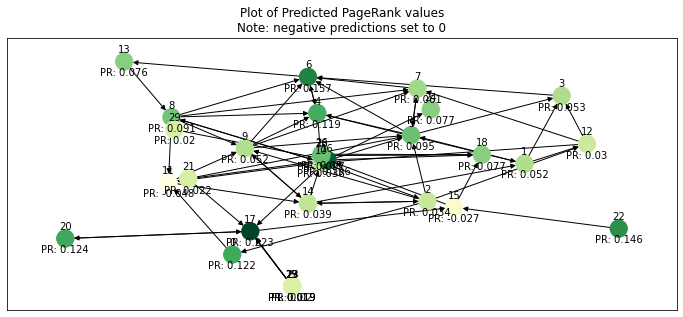

Ground Truth vs. Predictions
--------------------------


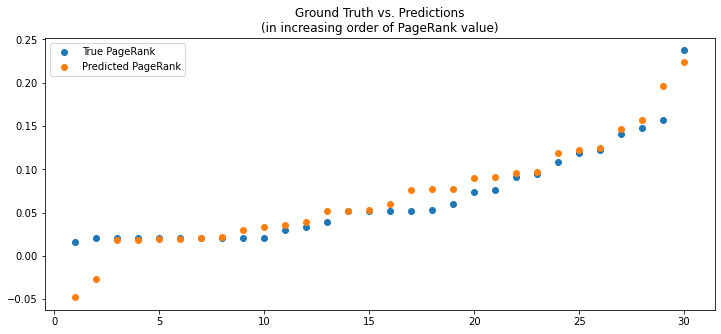

In [59]:
GNNrelaxation_model_adamw.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.0095, Iterations: 6
	Validation -- Mean Loss: 0.0141, Iterations: 6
Epoch -- 200
	Training -- Mean Loss: 0.0058, Iterations: 6
	Validation -- Mean Loss: 0.0098, Iterations: 6
Epoch -- 300
	Training -- Mean Loss: 0.0031, Iterations: 6
	Validation -- Mean Loss: 0.0074, Iterations: 6
Epoch -- 400
	Training -- Mean Loss: 0.0016, Iterations: 8
	Validation -- Mean Loss: 0.0065, Iterations: 8
Epoch -- 500
	Training -- Mean Loss: 0.001, Iterations: 9
	Validation -- Mean Loss: 0.0059, Iterations: 9
Epoch -- 600
	Training -- Mean Loss: 0.0008, Iterations: 9
	Validation -- Mean Loss: 0.0055, Iterations: 9
Epoch -- 700
	Training -- Mean Loss: 0.0006, Iterations: 9
	Validation -- Mean Loss: 0.0051, Iterations: 9
Epoch -- 800
	Training -- Mean Loss: 0.0004, Iterations: 8
	Validation -- Mean Loss: 0.0049, Iterations: 8
Epoch -- 900
	Training -- Mean Loss: 0.0003, Iterations: 8
	Validation -- Mean Loss: 0.0048, Iterations: 8
Epoch -- 1000
	Training -- Mean Loss: 

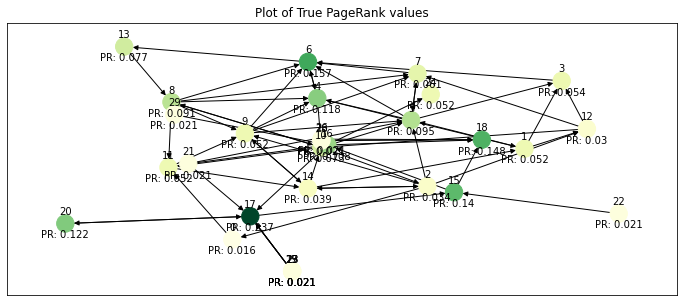

Plot with predicted labels
--------------------------


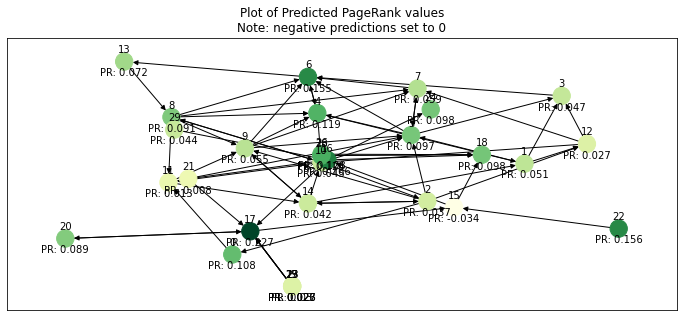

Ground Truth vs. Predictions
--------------------------


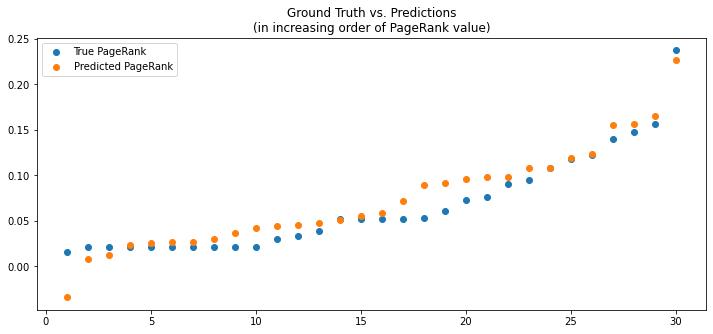

In [60]:
GNNrelaxation_model_adamax.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.0119, Iterations: 5
	Validation -- Mean Loss: 0.012, Iterations: 5
Epoch -- 200
	Training -- Mean Loss: 0.0116, Iterations: 5
	Validation -- Mean Loss: 0.0116, Iterations: 5
Epoch -- 300
	Training -- Mean Loss: 0.0112, Iterations: 5
	Validation -- Mean Loss: 0.0111, Iterations: 5
Epoch -- 400
	Training -- Mean Loss: 0.0108, Iterations: 5
	Validation -- Mean Loss: 0.0107, Iterations: 5
Epoch -- 500
	Training -- Mean Loss: 0.0103, Iterations: 5
	Validation -- Mean Loss: 0.0102, Iterations: 5
Epoch -- 600
	Training -- Mean Loss: 0.0099, Iterations: 5
	Validation -- Mean Loss: 0.0097, Iterations: 5
Epoch -- 700
	Training -- Mean Loss: 0.0095, Iterations: 4
	Validation -- Mean Loss: 0.0092, Iterations: 4
Epoch -- 800
	Training -- Mean Loss: 0.0091, Iterations: 4
	Validation -- Mean Loss: 0.0087, Iterations: 4
Epoch -- 900
	Training -- Mean Loss: 0.0087, Iterations: 4
	Validation -- Mean Loss: 0.0083, Iterations: 4
Epoch -- 1000
	Training -- Mean Loss: 

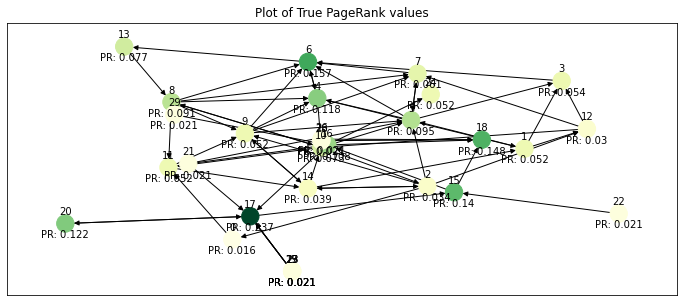

Plot with predicted labels
--------------------------


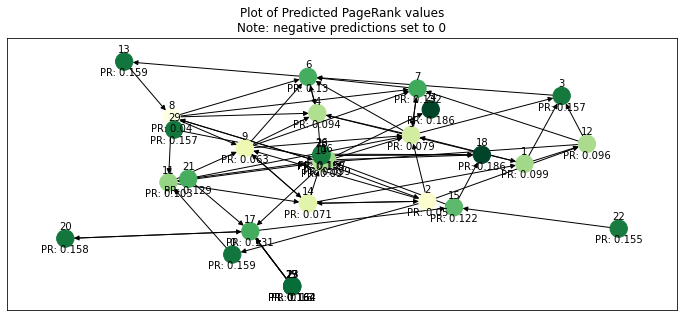

Ground Truth vs. Predictions
--------------------------


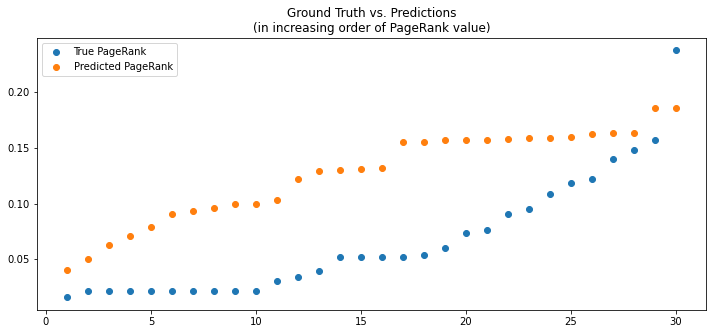

In [61]:
GNNrelaxation_model_adadelta.run(
    print_node_results=True, 
    print_graph_results=True
)

Epoch -- 100
	Training -- Mean Loss: 0.0398, Iterations: 7
	Validation -- Mean Loss: 0.032, Iterations: 7
Epoch -- 200
	Training -- Mean Loss: 0.0164, Iterations: 7
	Validation -- Mean Loss: 0.0107, Iterations: 7
Epoch -- 300
	Training -- Mean Loss: 0.0083, Iterations: 7
	Validation -- Mean Loss: 0.0039, Iterations: 7
Epoch -- 400
	Training -- Mean Loss: 0.0055, Iterations: 7
	Validation -- Mean Loss: 0.0018, Iterations: 7
Epoch -- 500
	Training -- Mean Loss: 0.0045, Iterations: 7
	Validation -- Mean Loss: 0.0013, Iterations: 7
Epoch -- 600
	Training -- Mean Loss: 0.0042, Iterations: 7
	Validation -- Mean Loss: 0.0012, Iterations: 7
Epoch -- 700
	Training -- Mean Loss: 0.004, Iterations: 7
	Validation -- Mean Loss: 0.0012, Iterations: 7
Epoch -- 800
	Training -- Mean Loss: 0.004, Iterations: 7
	Validation -- Mean Loss: 0.0013, Iterations: 7
Epoch -- 900
	Training -- Mean Loss: 0.0039, Iterations: 7
	Validation -- Mean Loss: 0.0013, Iterations: 7
Epoch -- 1000
	Training -- Mean Loss: 0.

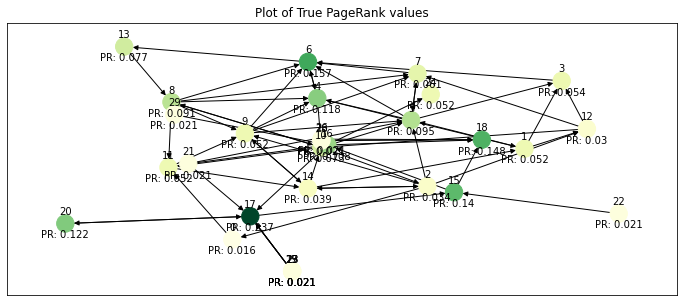

Plot with predicted labels
--------------------------


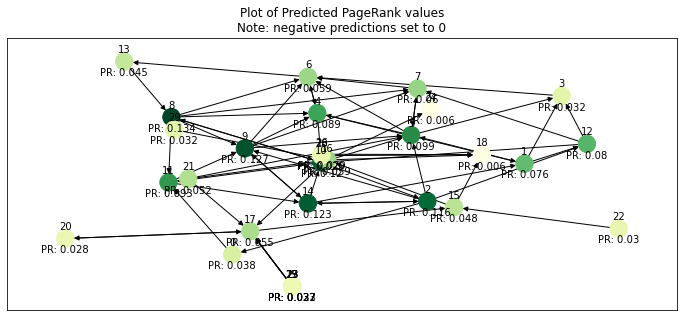

Ground Truth vs. Predictions
--------------------------


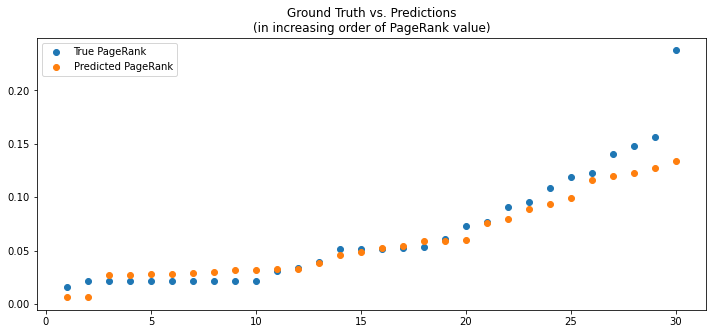

In [62]:
GNNrelaxation_model_SGD.run(
    print_node_results=True, 
    print_graph_results=True
)

<u>Convolutional GNN models (graph with noise as feature):</u>

Epoch 0,	loss: 0.023292;		val loss 0.006521
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 40             ####
Final train loss: 0.001419, validation loss: 0.0006045562331564724.
Test loss: 8.7e-05


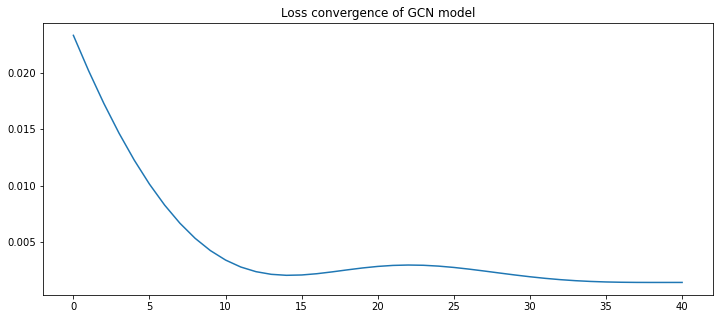



Plot with true labels
---------------------


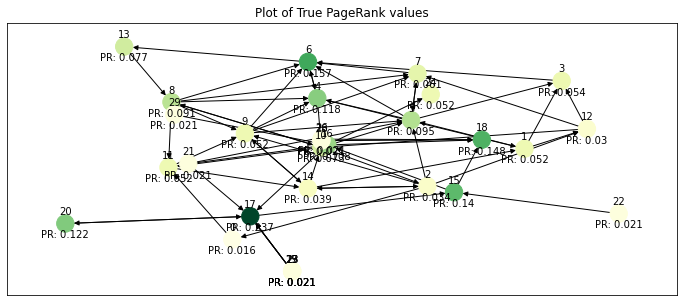

Plot with predicted labels
--------------------------


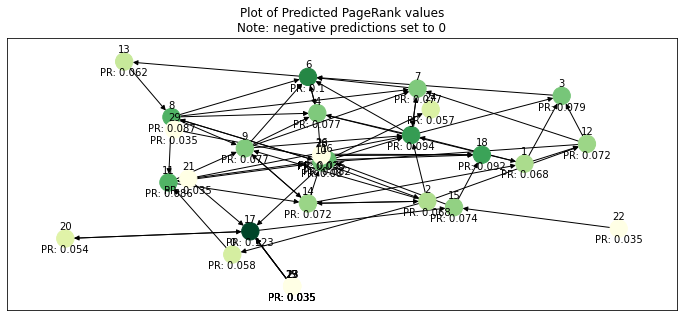

Ground Truth vs. Predictions
--------------------------


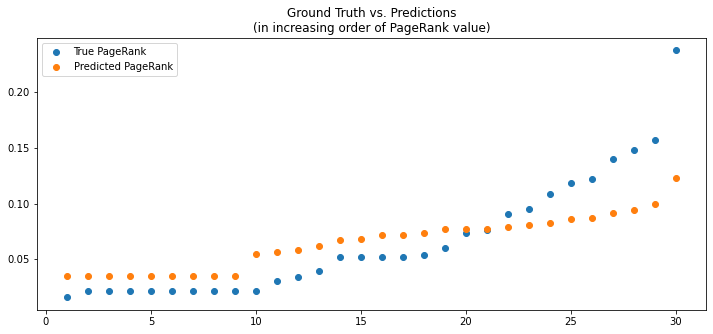

In [63]:
GCN_model_adam_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.001916;		val loss 0.000257
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 12             ####
Final train loss: 0.001747, validation loss: 0.0003108363598585129.
Test loss: 4.7e-05


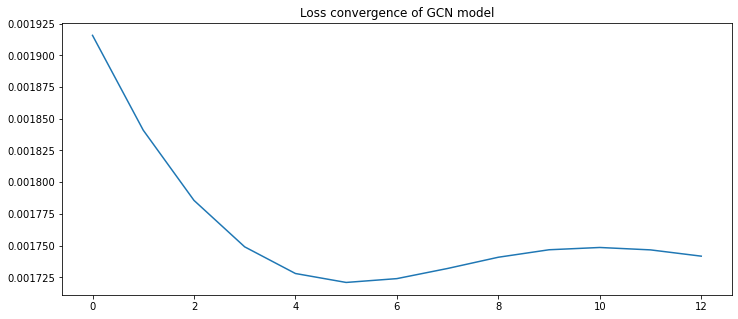



Plot with true labels
---------------------


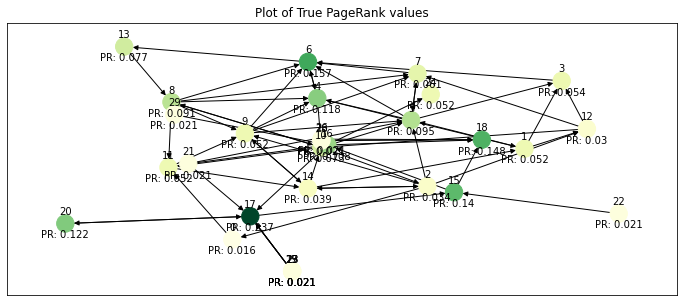

Plot with predicted labels
--------------------------


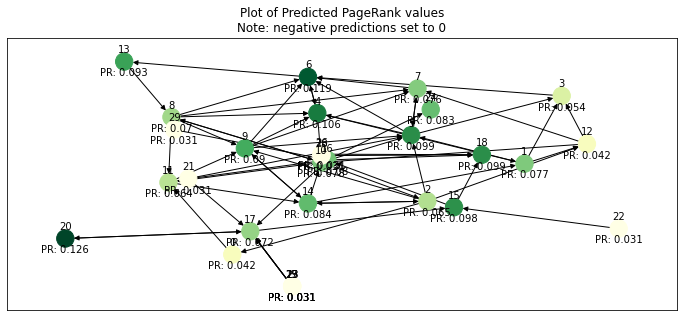

Ground Truth vs. Predictions
--------------------------


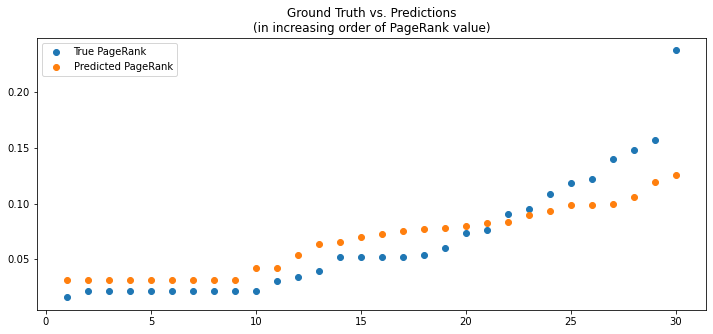

In [64]:
GCN_model_adamw_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.106422;		val loss 0.026995
Epoch 50,	loss: 0.009032;		val loss 0.003787
Epoch 100,	loss: 0.006489;		val loss 0.002711
Epoch 150,	loss: 0.005085;		val loss 0.0022
Epoch 200,	loss: 0.004038;		val loss 0.001806
Epoch 250,	loss: 0.003276;		val loss 0.001496
Epoch 300,	loss: 0.00272;		val loss 0.001242
Epoch 350,	loss: 0.002182;		val loss 0.000959
Epoch 400,	loss: 0.001797;		val loss 0.000762
Epoch 450,	loss: 0.00154;		val loss 0.000623
Epoch 500,	loss: 0.001376;		val loss 0.000529
Epoch 550,	loss: 0.001273;		val loss 0.000466
Epoch 600,	loss: 0.001207;		val loss 0.000424
Epoch 650,	loss: 0.001164;		val loss 0.000396
Epoch 700,	loss: 0.001133;		val loss 0.000376
Epoch 750,	loss: 0.001105;		val loss 0.00036
Epoch 800,	loss: 0.001079;		val loss 0.000345
Epoch 850,	loss: 0.001057;		val loss 0.000333
Epoch 900,	loss: 0.001036;		val loss 0.000322
Epoch 950,	loss: 0.001017;		val loss 0.000311
Final train loss: 0.001, validation loss: 0.000302.
Test loss: 0.00012


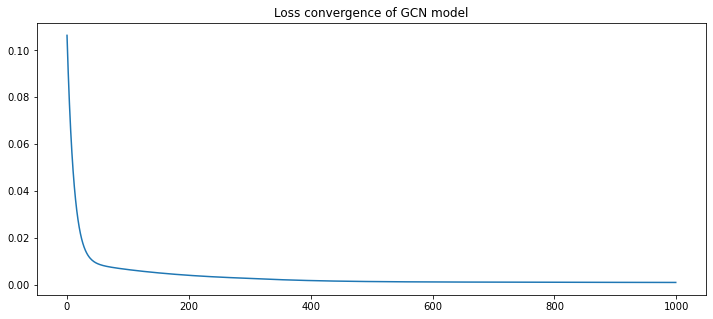



Plot with true labels
---------------------


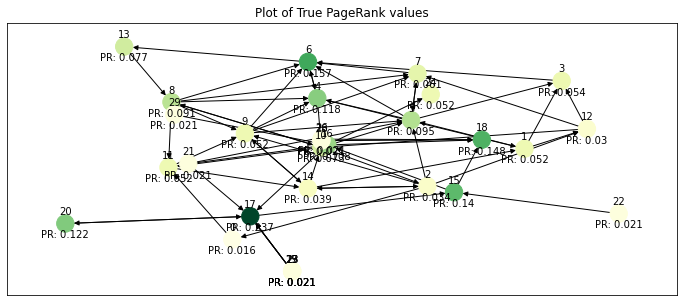

Plot with predicted labels
--------------------------


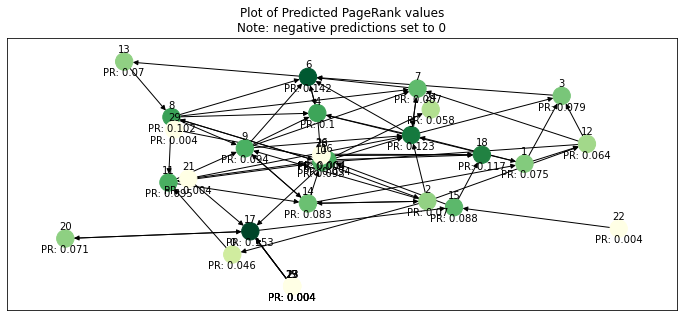

Ground Truth vs. Predictions
--------------------------


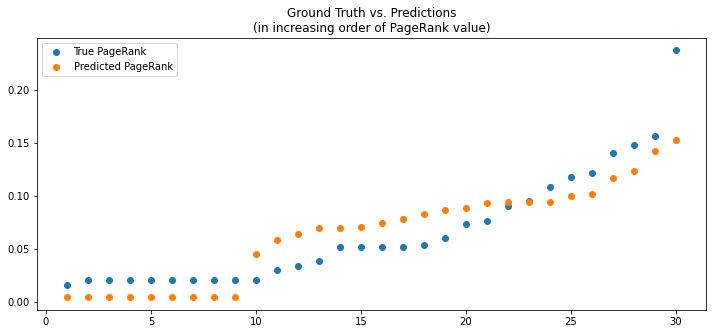

In [65]:
GCN_model_adamax_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.013355;		val loss 0.004512
Epoch 50,	loss: 0.013026;		val loss 0.004427
Epoch 100,	loss: 0.012653;		val loss 0.00433
Epoch 150,	loss: 0.012248;		val loss 0.004225
Epoch 200,	loss: 0.01182;		val loss 0.004113
Epoch 250,	loss: 0.011375;		val loss 0.003996
Epoch 300,	loss: 0.010919;		val loss 0.003876
Epoch 350,	loss: 0.010457;		val loss 0.003753
Epoch 400,	loss: 0.009995;		val loss 0.003628
Epoch 450,	loss: 0.009539;		val loss 0.003504
Epoch 500,	loss: 0.009091;		val loss 0.00338
Epoch 550,	loss: 0.008655;		val loss 0.003257
Epoch 600,	loss: 0.008227;		val loss 0.003135
Epoch 650,	loss: 0.007809;		val loss 0.003015
Epoch 700,	loss: 0.007403;		val loss 0.002897
Epoch 750,	loss: 0.007009;		val loss 0.002781
Epoch 800,	loss: 0.006631;		val loss 0.002669
Epoch 850,	loss: 0.006271;		val loss 0.00256
Epoch 900,	loss: 0.005932;		val loss 0.002455
Epoch 950,	loss: 0.005611;		val loss 0.002352
Final train loss: 0.005321, validation loss: 0.002257.
Test loss: 0.000476


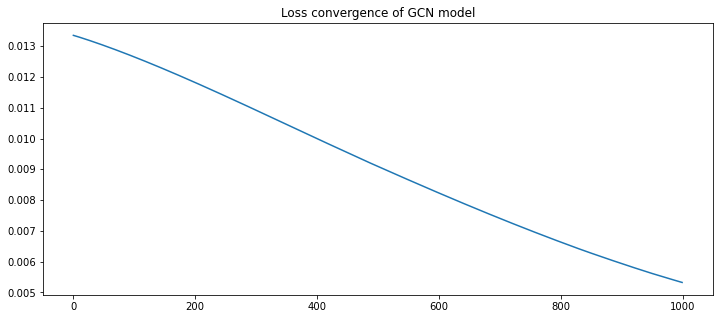



Plot with true labels
---------------------


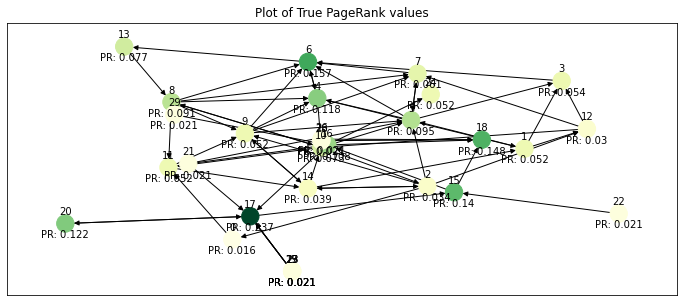

Plot with predicted labels
--------------------------


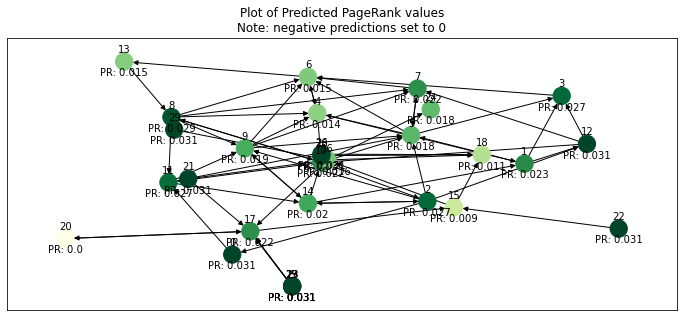

Ground Truth vs. Predictions
--------------------------


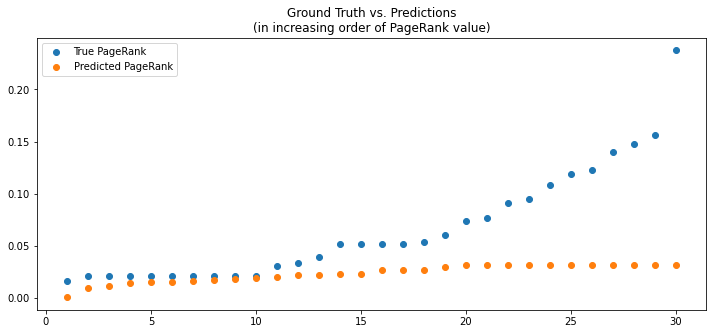

In [66]:
GCN_model_adadelta_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.008413;		val loss 0.002911
Epoch 50,	loss: 0.002172;		val loss 0.000952
Epoch 100,	loss: 0.001464;		val loss 0.000577
Epoch 150,	loss: 0.001333;		val loss 0.000467
Epoch 200,	loss: 0.00127;		val loss 0.000419
Epoch 250,	loss: 0.001219;		val loss 0.000389
Epoch 300,	loss: 0.001175;		val loss 0.000365
Epoch 350,	loss: 0.001133;		val loss 0.000346
Epoch 400,	loss: 0.001094;		val loss 0.000328
Epoch 450,	loss: 0.001057;		val loss 0.000311
Epoch 500,	loss: 0.001024;		val loss 0.000295
Epoch 550,	loss: 0.000992;		val loss 0.00028
Epoch 600,	loss: 0.000963;		val loss 0.000266
Epoch 650,	loss: 0.000935;		val loss 0.000253
Epoch 700,	loss: 0.00091;		val loss 0.00024
Epoch 750,	loss: 0.000885;		val loss 0.000229
Epoch 800,	loss: 0.000862;		val loss 0.000218
Epoch 850,	loss: 0.000841;		val loss 0.000208
Epoch 900,	loss: 0.00082;		val loss 0.000199
Epoch 950,	loss: 0.000801;		val loss 0.00019
Final train loss: 0.000783, validation loss: 0.000181.
Test loss: 7e-05


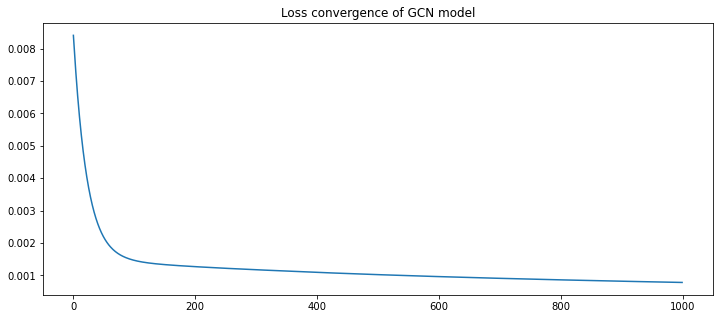



Plot with true labels
---------------------


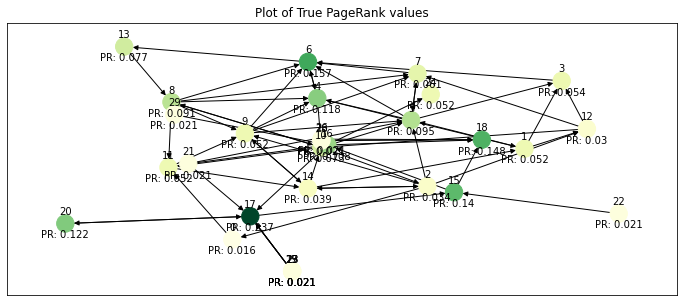

Plot with predicted labels
--------------------------


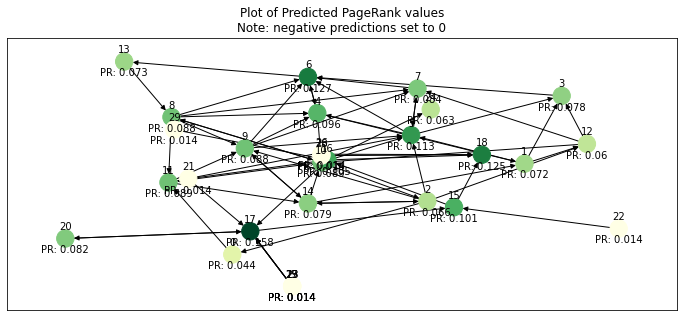

Ground Truth vs. Predictions
--------------------------


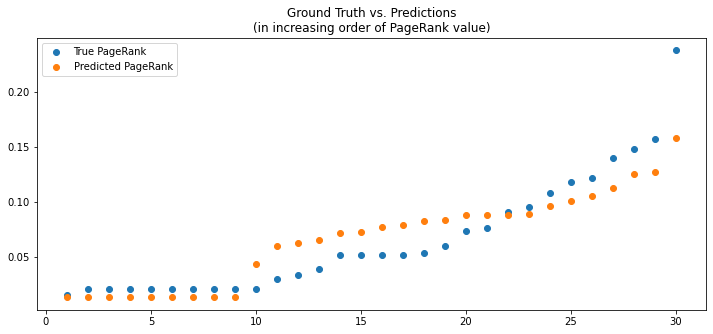

In [67]:
GCN_model_SGD_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.968807;		val loss 0.201602
Epoch 50,	loss: 0.035609;		val loss 0.012332
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 73             ####
Final train loss: 0.021583, validation loss: 0.010896507650613785.
Test loss: 0.002604


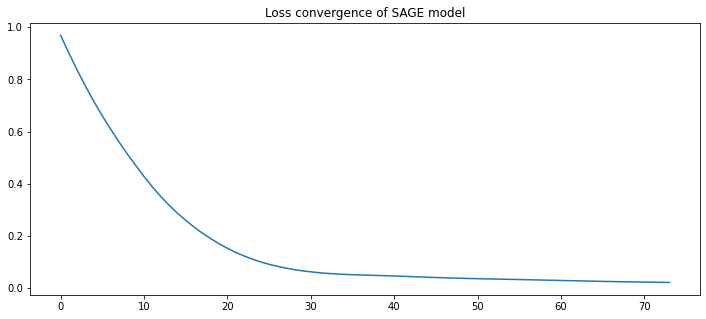



Plot with true labels
---------------------


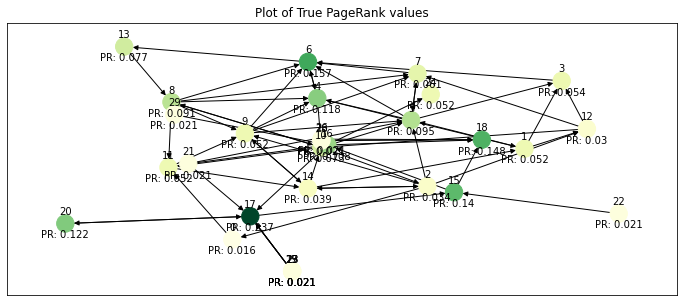

Plot with predicted labels
--------------------------


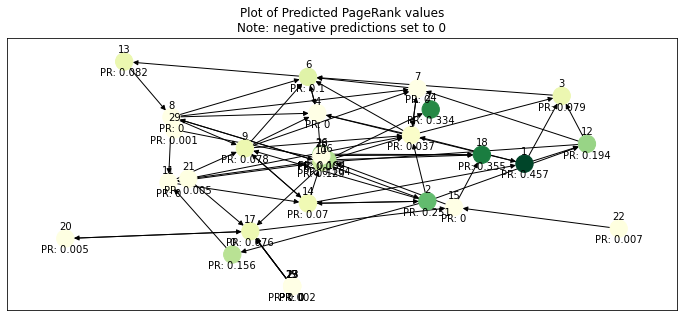

Ground Truth vs. Predictions
--------------------------


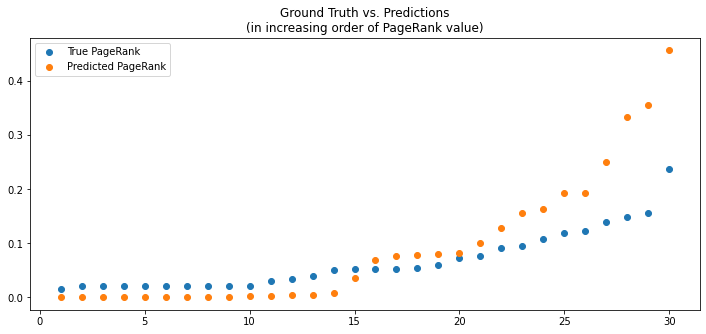

In [68]:
SAGE_model_adam_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.018835;		val loss 0.005239
Epoch 50,	loss: 0.003139;		val loss 0.001139
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 53             ####
Final train loss: 0.00313, validation loss: 0.0011415551416575909.
Test loss: 0.000341


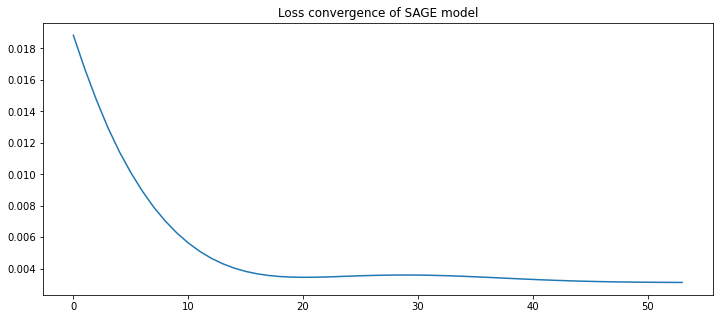



Plot with true labels
---------------------


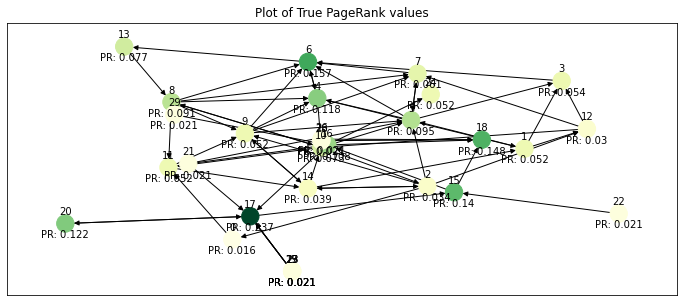

Plot with predicted labels
--------------------------


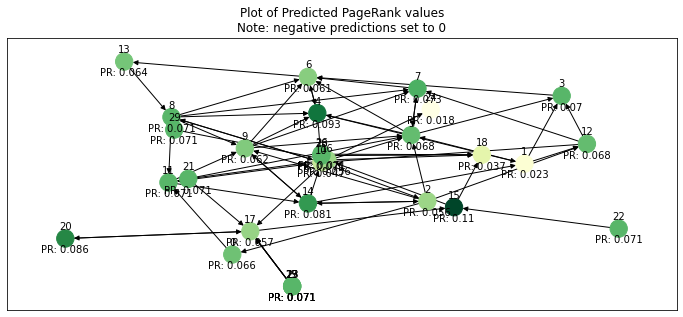

Ground Truth vs. Predictions
--------------------------


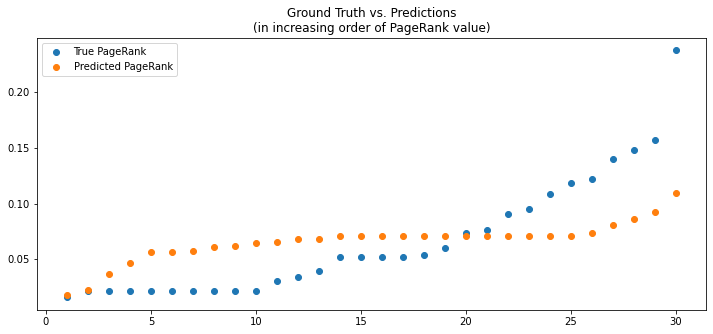

In [69]:
SAGE_model_adamw_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.484895;		val loss 0.108273
Epoch 50,	loss: 0.025844;		val loss 0.014291
Epoch 100,	loss: 0.020175;		val loss 0.01339
Epoch 150,	loss: 0.016699;		val loss 0.01216
Epoch 200,	loss: 0.013932;		val loss 0.011118
Epoch 250,	loss: 0.011666;		val loss 0.010221
Epoch 300,	loss: 0.009807;		val loss 0.009439
Epoch 350,	loss: 0.008276;		val loss 0.008776
Epoch 400,	loss: 0.007;		val loss 0.008169
Epoch 450,	loss: 0.005937;		val loss 0.007652
Epoch 500,	loss: 0.005051;		val loss 0.007213
Epoch 550,	loss: 0.004313;		val loss 0.006831
Epoch 600,	loss: 0.003729;		val loss 0.006449
Epoch 650,	loss: 0.00324;		val loss 0.006088
Epoch 700,	loss: 0.002828;		val loss 0.005772
Epoch 750,	loss: 0.002481;		val loss 0.005494
Epoch 800,	loss: 0.002194;		val loss 0.005253
Epoch 850,	loss: 0.00195;		val loss 0.005028
Epoch 900,	loss: 0.00175;		val loss 0.004856
Epoch 950,	loss: 0.001589;		val loss 0.004731
Final train loss: 0.001462, validation loss: 0.004611.
Test loss: 0.001765


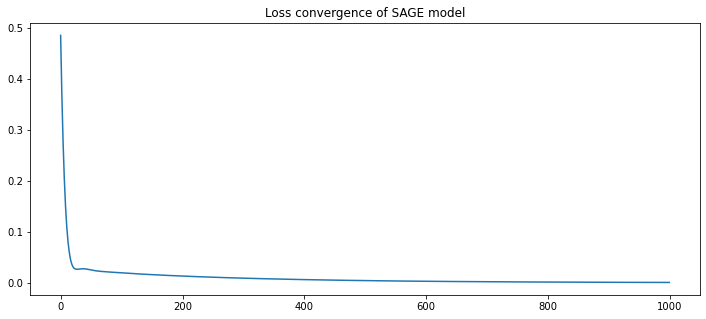



Plot with true labels
---------------------


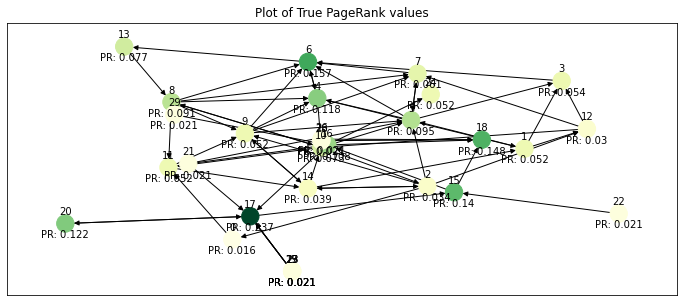

Plot with predicted labels
--------------------------


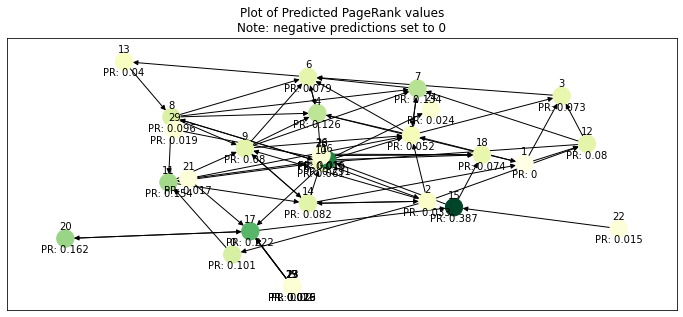

Ground Truth vs. Predictions
--------------------------


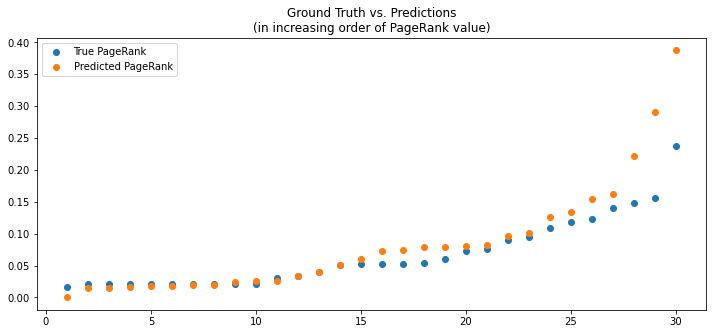

In [70]:
SAGE_model_adamax_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.118421;		val loss 0.107499
Epoch 50,	loss: 0.113961;		val loss 0.105645
Epoch 100,	loss: 0.108977;		val loss 0.103553
Epoch 150,	loss: 0.103622;		val loss 0.101305
Epoch 200,	loss: 0.09804;		val loss 0.098978
Epoch 250,	loss: 0.092421;		val loss 0.096568
Epoch 300,	loss: 0.086856;		val loss 0.094104
Epoch 350,	loss: 0.081415;		val loss 0.091608
Epoch 400,	loss: 0.076162;		val loss 0.089103
Epoch 450,	loss: 0.071144;		val loss 0.086605
Epoch 500,	loss: 0.066416;		val loss 0.084131
Epoch 550,	loss: 0.062164;		val loss 0.081708
Epoch 600,	loss: 0.058187;		val loss 0.079317
Epoch 650,	loss: 0.054503;		val loss 0.076965
Epoch 700,	loss: 0.051212;		val loss 0.074707
Epoch 750,	loss: 0.048228;		val loss 0.072497
Epoch 800,	loss: 0.045528;		val loss 0.070328
Epoch 850,	loss: 0.0431;		val loss 0.068197
Epoch 900,	loss: 0.040923;		val loss 0.066094
Epoch 950,	loss: 0.038969;		val loss 0.06398
Final train loss: 0.037219, validation loss: 0.061808.
Test loss: 0.021734


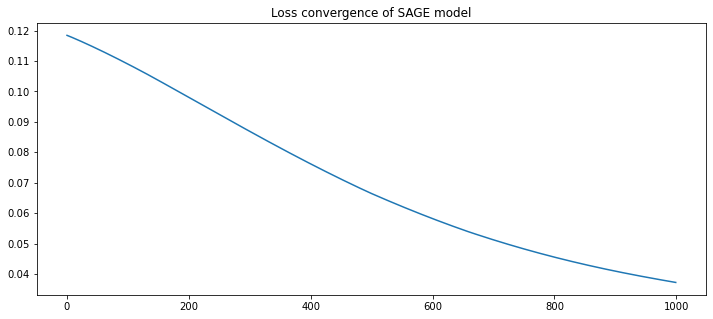



Plot with true labels
---------------------


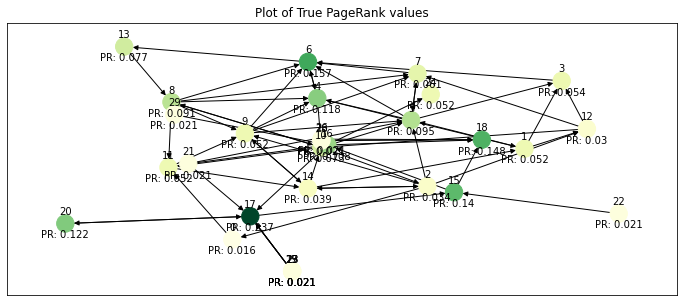

Plot with predicted labels
--------------------------


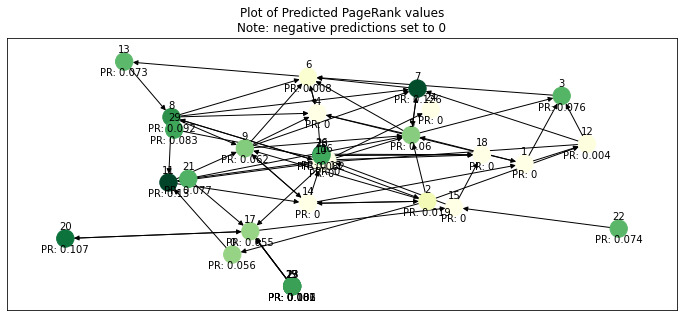

Ground Truth vs. Predictions
--------------------------


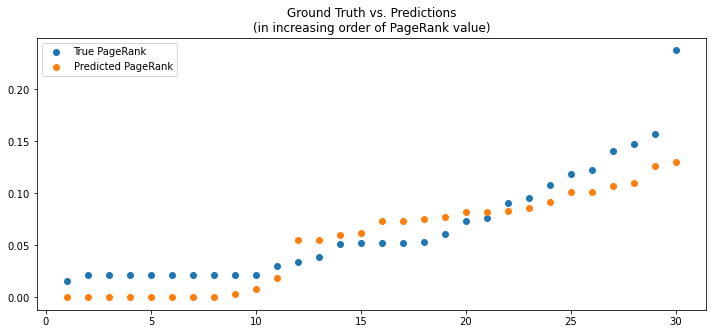

In [71]:
SAGE_model_adadelta_noise.run(print_graph_results=True)

Epoch 0,	loss: 0.093556;		val loss 0.100463
Epoch 50,	loss: 0.06596;		val loss 0.078498
Epoch 100,	loss: 0.049398;		val loss 0.063604
Epoch 150,	loss: 0.039011;		val loss 0.053235
Epoch 200,	loss: 0.032237;		val loss 0.04577
Epoch 250,	loss: 0.027641;		val loss 0.040221
Epoch 300,	loss: 0.024388;		val loss 0.035972
Epoch 350,	loss: 0.021982;		val loss 0.032629
Epoch 400,	loss: 0.020123;		val loss 0.029933
Epoch 450,	loss: 0.018626;		val loss 0.027709
Epoch 500,	loss: 0.017378;		val loss 0.025836
Epoch 550,	loss: 0.016304;		val loss 0.024231
Epoch 600,	loss: 0.015358;		val loss 0.022834
Epoch 650,	loss: 0.014511;		val loss 0.0216
Epoch 700,	loss: 0.013741;		val loss 0.020498
Epoch 750,	loss: 0.013035;		val loss 0.019505
Epoch 800,	loss: 0.012384;		val loss 0.0186
Epoch 850,	loss: 0.011779;		val loss 0.017771
Epoch 900,	loss: 0.011216;		val loss 0.017007
Epoch 950,	loss: 0.010689;		val loss 0.016298
Final train loss: 0.010207, validation loss: 0.015651.
Test loss: 0.002734


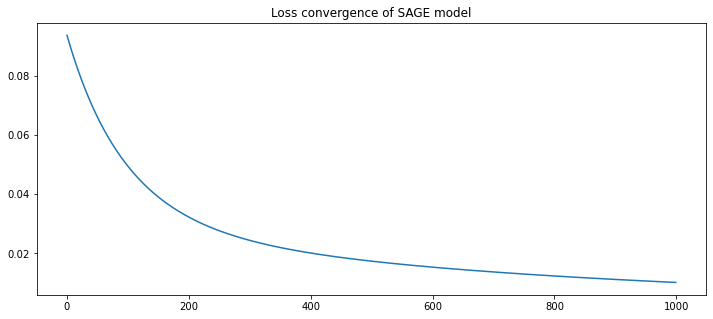



Plot with true labels
---------------------


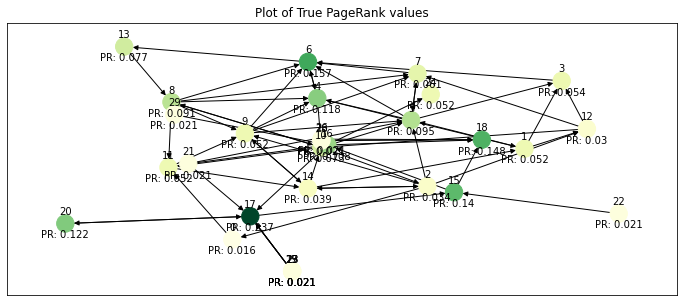

Plot with predicted labels
--------------------------


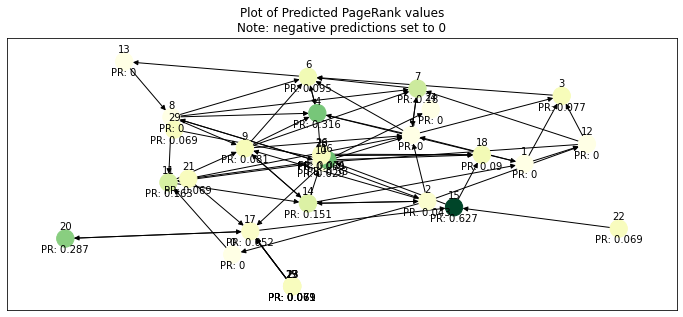

Ground Truth vs. Predictions
--------------------------


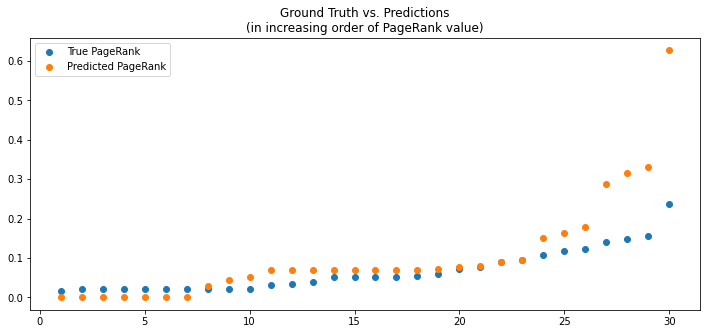

In [72]:
SAGE_model_SGD_noise.run(print_graph_results=True)

<u>Convolutional GNN models (graph with torcheye as feature):</u>

Epoch 0,	loss: 0.013845;		val loss 0.002943
Epoch 50,	loss: 0.000152;		val loss 6.2e-05
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 79             ####
Final train loss: 7.1e-05, validation loss: 5.122947186464444e-05.
Test loss: 6.4e-05


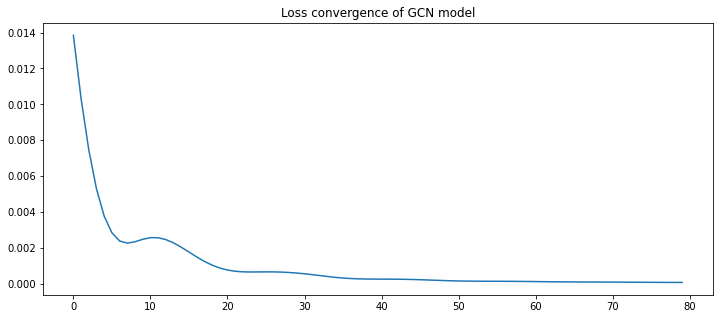



Plot with true labels
---------------------


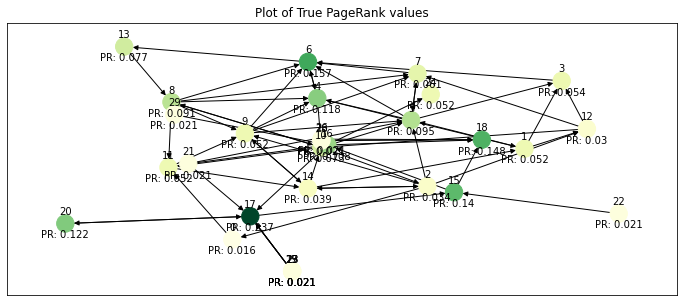

Plot with predicted labels
--------------------------


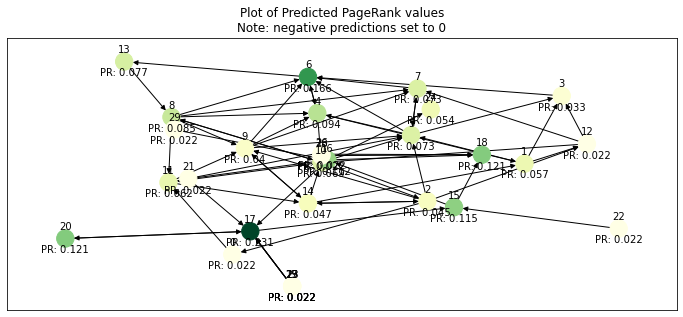

Ground Truth vs. Predictions
--------------------------


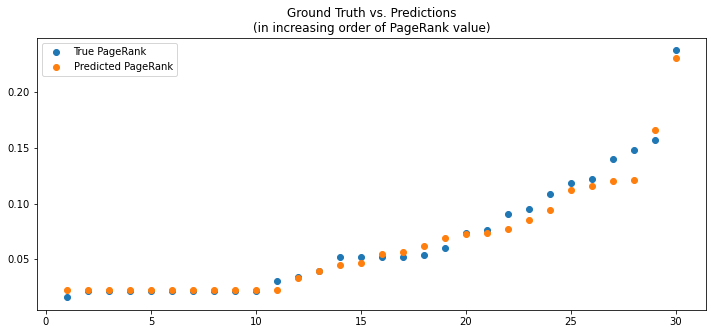

In [73]:
GCN_model_adam_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.010397;		val loss 0.004447
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 44             ####
Final train loss: 0.000841, validation loss: 0.0011934065259993076.
Test loss: 9.1e-05


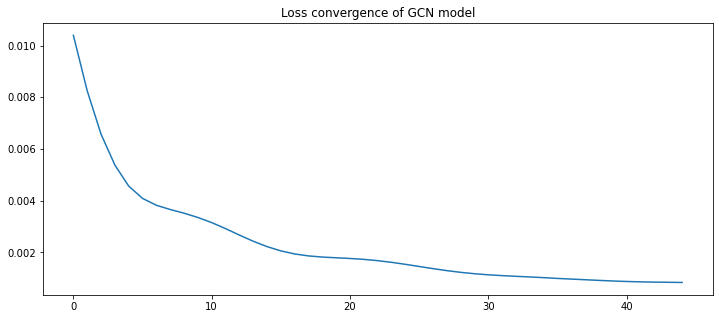



Plot with true labels
---------------------


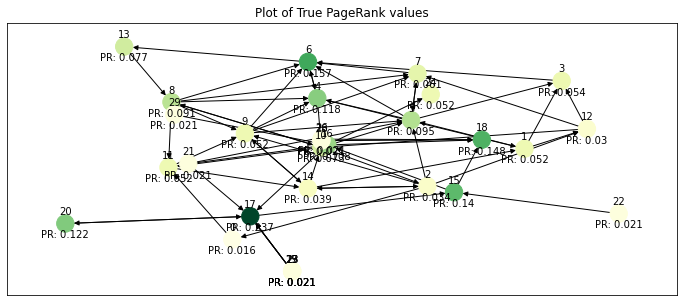

Plot with predicted labels
--------------------------


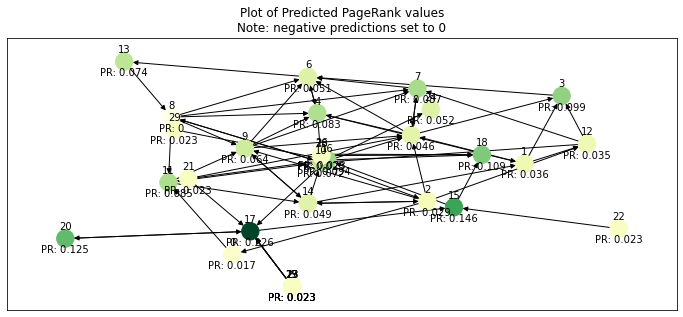

Ground Truth vs. Predictions
--------------------------


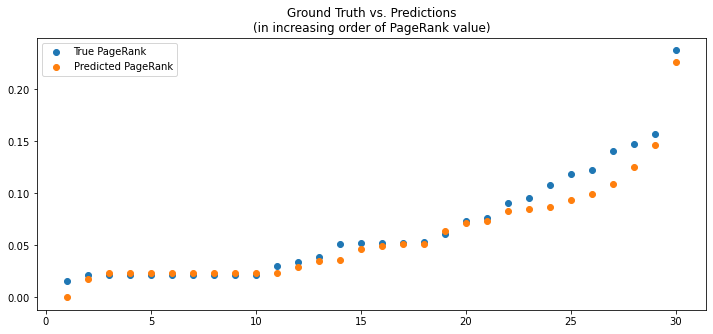

In [74]:
GCN_model_adamw_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.010624;		val loss 0.002667
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 47             ####
Final train loss: 0.000973, validation loss: 0.000839133863337338.
Test loss: 0.000173


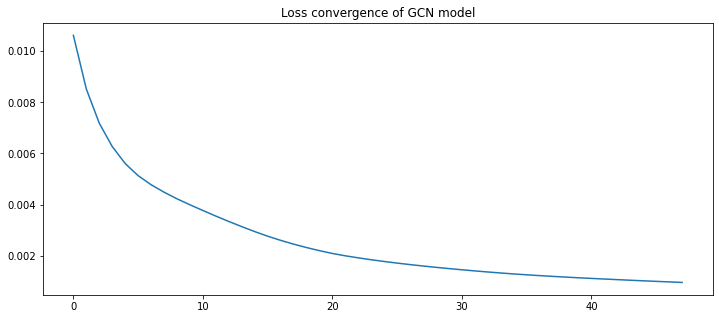



Plot with true labels
---------------------


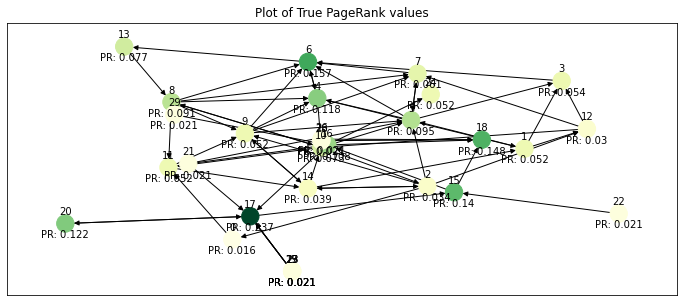

Plot with predicted labels
--------------------------


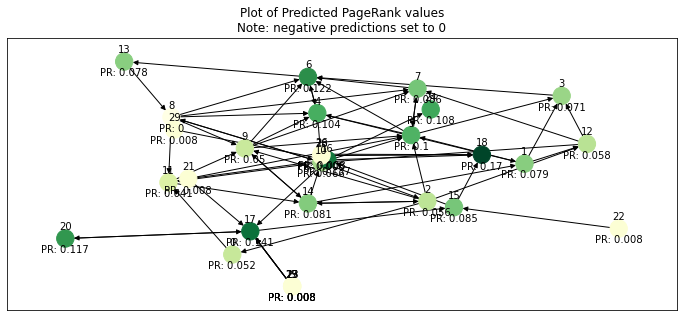

Ground Truth vs. Predictions
--------------------------


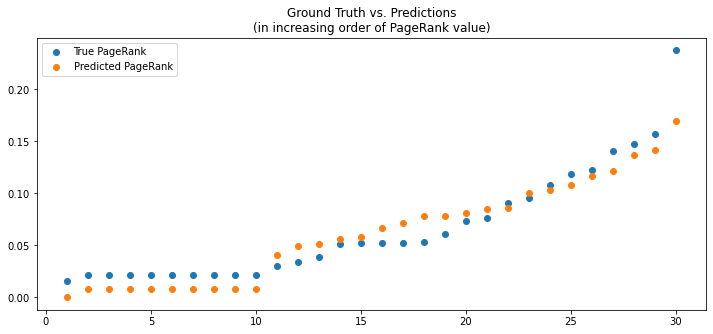

In [75]:
GCN_model_adamax_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.011929;		val loss 0.003217
Epoch 50,	loss: 0.011464;		val loss 0.003057
Epoch 100,	loss: 0.01096;		val loss 0.002884
Epoch 150,	loss: 0.010435;		val loss 0.002704
Epoch 200,	loss: 0.009904;		val loss 0.002523
Epoch 250,	loss: 0.009377;		val loss 0.002343
Epoch 300,	loss: 0.008861;		val loss 0.002167
Epoch 350,	loss: 0.008368;		val loss 0.001997
Epoch 400,	loss: 0.007961;		val loss 0.001846
Epoch 450,	loss: 0.007575;		val loss 0.001699
Epoch 500,	loss: 0.00721;		val loss 0.00156
Epoch 550,	loss: 0.006866;		val loss 0.001427
Epoch 600,	loss: 0.006545;		val loss 0.001302
Epoch 650,	loss: 0.006246;		val loss 0.001186
Epoch 700,	loss: 0.005971;		val loss 0.001078
Epoch 750,	loss: 0.005718;		val loss 0.000979
Epoch 800,	loss: 0.005487;		val loss 0.000888
Epoch 850,	loss: 0.005278;		val loss 0.000806
Epoch 900,	loss: 0.005088;		val loss 0.000732
Epoch 950,	loss: 0.004916;		val loss 0.000667
Final train loss: 0.004764, validation loss: 0.00061.
Test loss: 0.0005


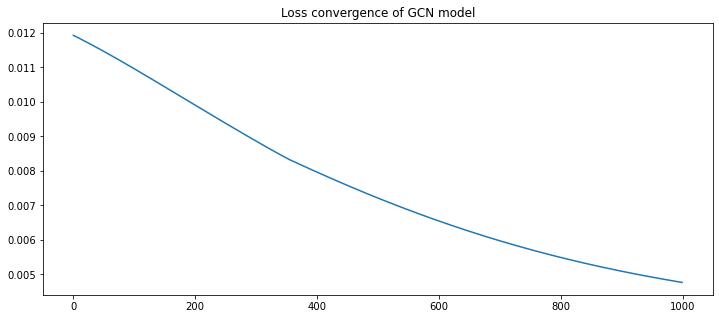



Plot with true labels
---------------------


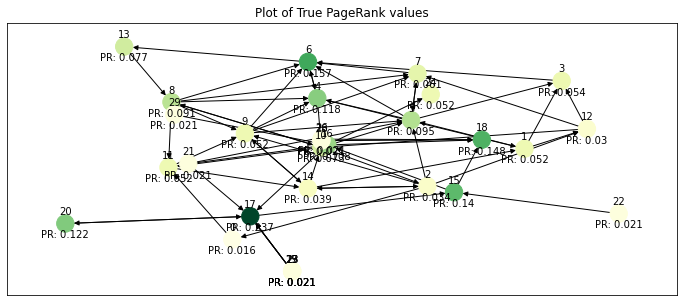

Plot with predicted labels
--------------------------


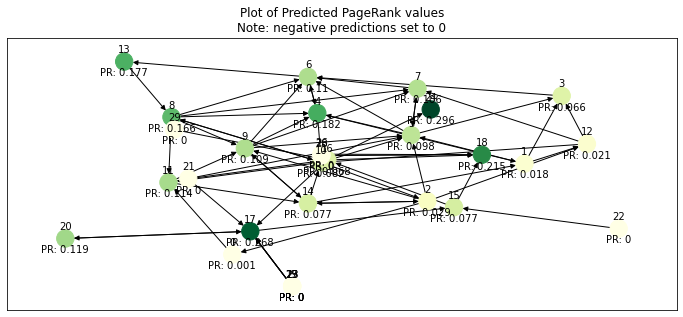

Ground Truth vs. Predictions
--------------------------


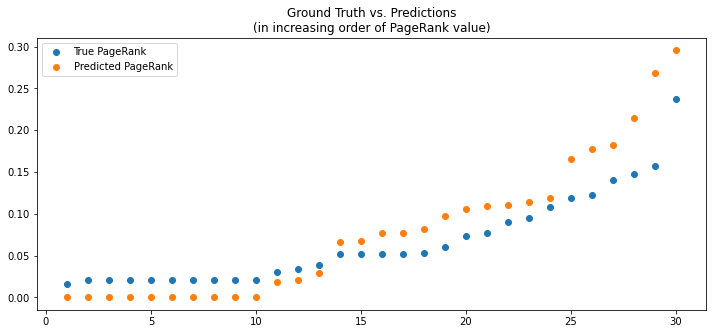

In [76]:
GCN_model_adadelta_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.013474;		val loss 0.003326
Epoch 50,	loss: 0.006361;		val loss 0.001565
Epoch 100,	loss: 0.003919;		val loss 0.000981
Epoch 150,	loss: 0.002986;		val loss 0.000782
Epoch 200,	loss: 0.002541;		val loss 0.000716
Epoch 250,	loss: 0.002263;		val loss 0.000667
Epoch 300,	loss: 0.00206;		val loss 0.000641
Epoch 350,	loss: 0.001895;		val loss 0.000624
Epoch 400,	loss: 0.00175;		val loss 0.000611
Epoch 450,	loss: 0.001613;		val loss 0.000599
Epoch 500,	loss: 0.001492;		val loss 0.000588
Epoch 550,	loss: 0.001386;		val loss 0.000579
Epoch 600,	loss: 0.001293;		val loss 0.000571
Epoch 650,	loss: 0.00121;		val loss 0.000564
Epoch 700,	loss: 0.001137;		val loss 0.000558
Epoch 750,	loss: 0.001073;		val loss 0.000551
Epoch 800,	loss: 0.001012;		val loss 0.000545
Epoch 850,	loss: 0.000954;		val loss 0.000538
Epoch 900,	loss: 0.000903;		val loss 0.000533
Epoch 950,	loss: 0.000858;		val loss 0.000528
Final train loss: 0.000819, validation loss: 0.000523.
Test loss: 0.000111


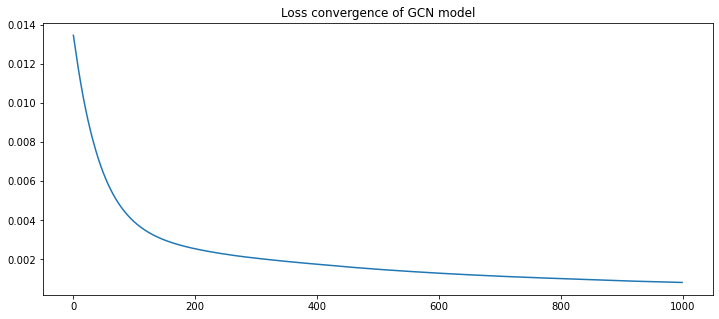



Plot with true labels
---------------------


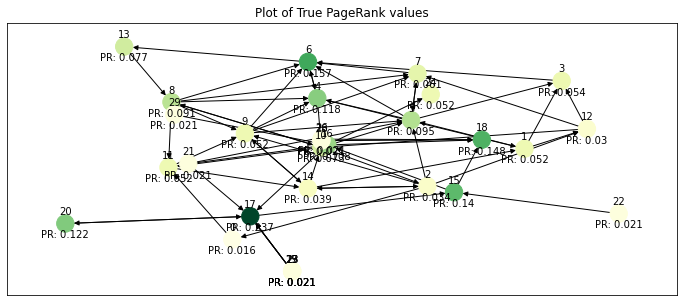

Plot with predicted labels
--------------------------


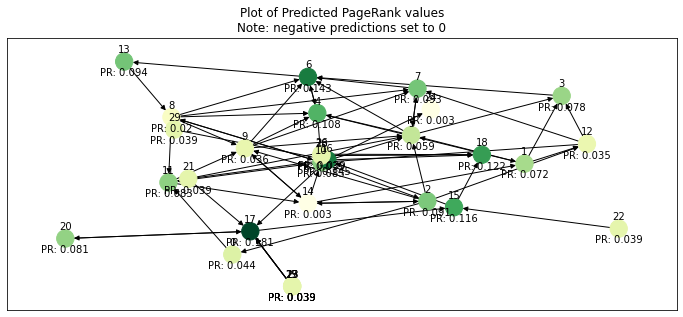

Ground Truth vs. Predictions
--------------------------


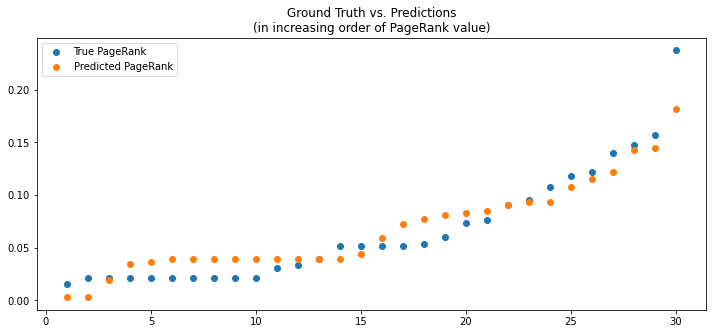

In [77]:
GCN_model_SGD_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.122596;		val loss 0.059699
Epoch 50,	loss: 0.001239;		val loss 0.015754
Epoch 100,	loss: 0.000183;		val loss 0.014527
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 130             ####
Final train loss: 7e-05, validation loss: 0.014483310282230377.
Test loss: 0.002721


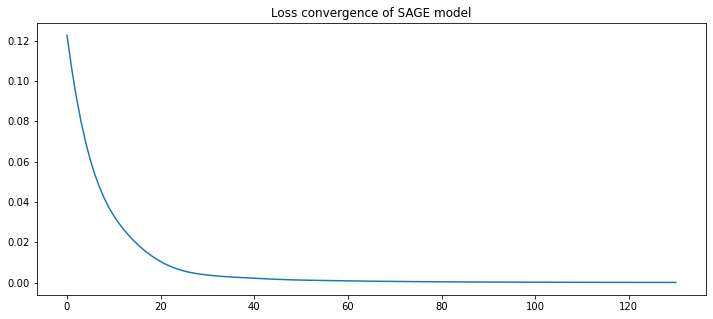



Plot with true labels
---------------------


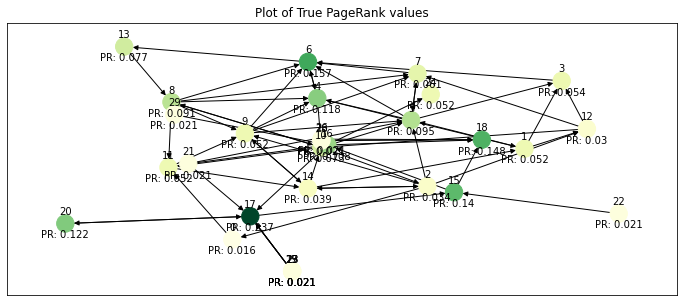

Plot with predicted labels
--------------------------


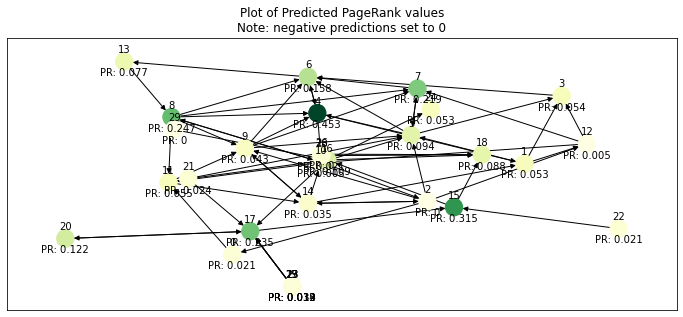

Ground Truth vs. Predictions
--------------------------


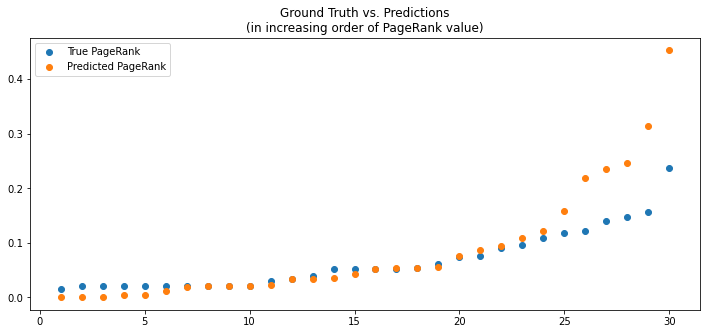

In [78]:
SAGE_model_adam_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.621713;		val loss 0.220647
Epoch 50,	loss: 0.003986;		val loss 0.02479
Epoch 100,	loss: 0.000784;		val loss 0.023584
Epoch 150,	loss: 0.000618;		val loss 0.022712
Epoch 200,	loss: 0.000531;		val loss 0.022298
Epoch 250,	loss: 0.000451;		val loss 0.022008
Epoch 300,	loss: 0.000379;		val loss 0.021735
Epoch 350,	loss: 0.000314;		val loss 0.021473
Epoch 400,	loss: 0.000256;		val loss 0.021225
Epoch 450,	loss: 0.000207;		val loss 0.02099
Epoch 500,	loss: 0.000164;		val loss 0.020769
Epoch 550,	loss: 0.000129;		val loss 0.020561
Epoch 600,	loss: 0.0001;		val loss 0.020362
Epoch 650,	loss: 7.6e-05;		val loss 0.020173
Epoch 700,	loss: 5.7e-05;		val loss 0.01999
Epoch 750,	loss: 4.3e-05;		val loss 0.019813
Epoch 800,	loss: 3.1e-05;		val loss 0.019638
Epoch 850,	loss: 2.3e-05;		val loss 0.019466
Epoch 900,	loss: 1.6e-05;		val loss 0.019295
Epoch 950,	loss: 1.1e-05;		val loss 0.019125
Final train loss: 8e-06, validation loss: 0.018958.
Test loss: 0.038831


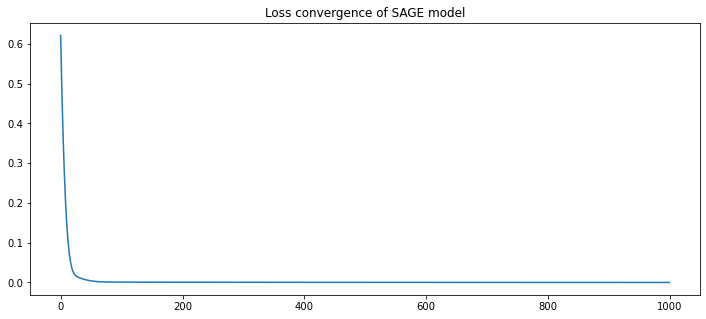



Plot with true labels
---------------------


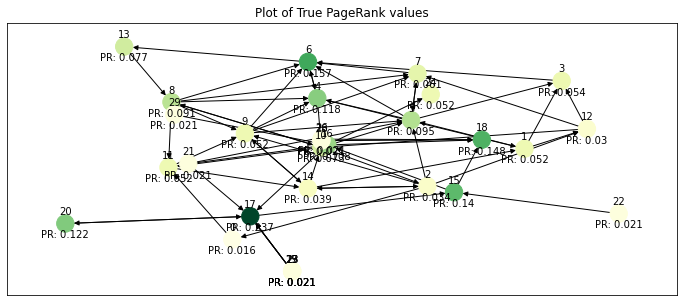

Plot with predicted labels
--------------------------


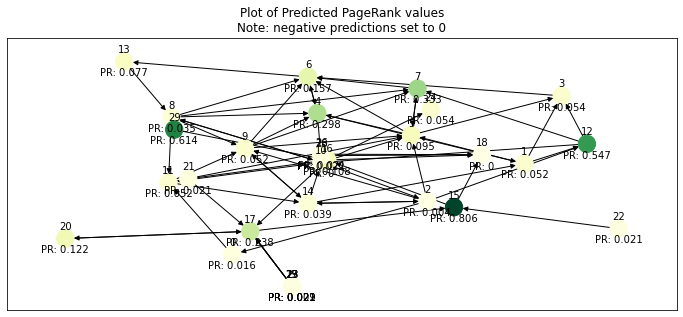

Ground Truth vs. Predictions
--------------------------


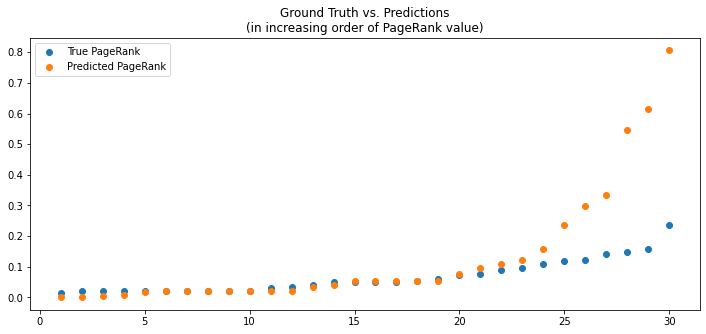

In [79]:
SAGE_model_adamw_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.184636;		val loss 0.02783
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 10             ####
Final train loss: 0.055541, validation loss: 0.048984307795763016.
Test loss: 0.016305


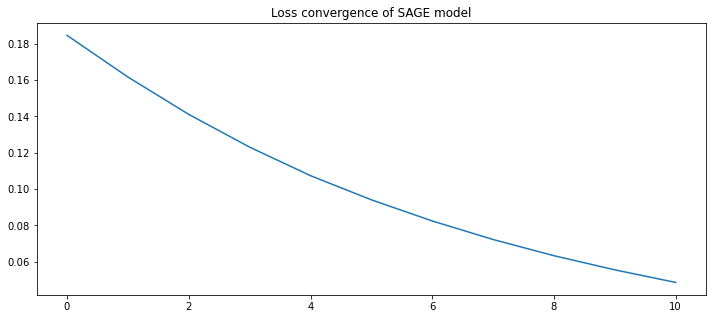



Plot with true labels
---------------------


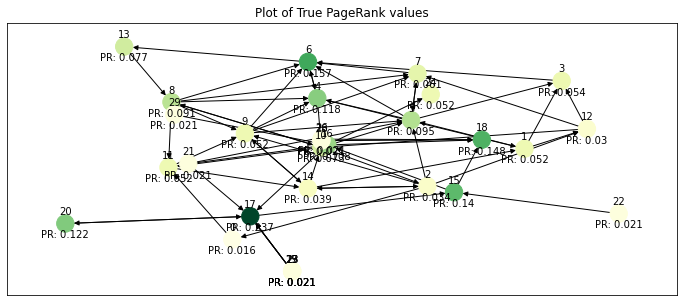

Plot with predicted labels
--------------------------


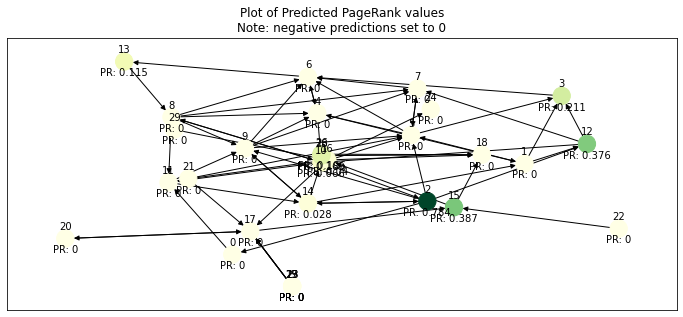

Ground Truth vs. Predictions
--------------------------


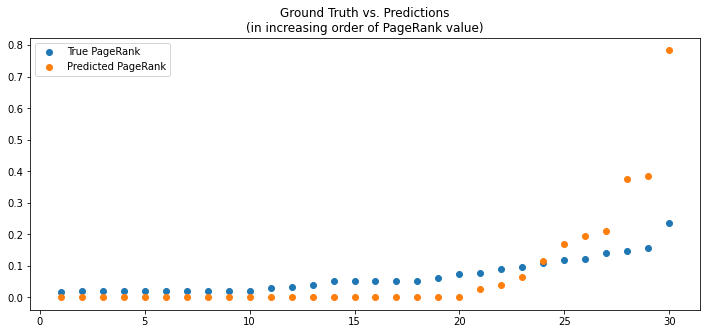

In [80]:
SAGE_model_adamax_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.521428;		val loss 0.175177
Epoch 50,	loss: 0.510926;		val loss 0.172468
Epoch 100,	loss: 0.498935;		val loss 0.16941
Epoch 150,	loss: 0.485867;		val loss 0.166103
Epoch 200,	loss: 0.471961;		val loss 0.162608
Epoch 250,	loss: 0.457415;		val loss 0.158973
Epoch 300,	loss: 0.442401;		val loss 0.155236
Epoch 350,	loss: 0.42708;		val loss 0.151434
Epoch 400,	loss: 0.411543;		val loss 0.147591
Epoch 450,	loss: 0.395897;		val loss 0.143731
Epoch 500,	loss: 0.380504;		val loss 0.139881
Epoch 550,	loss: 0.365178;		val loss 0.136091
Epoch 600,	loss: 0.349977;		val loss 0.132443
Epoch 650,	loss: 0.334956;		val loss 0.128822
Epoch 700,	loss: 0.320226;		val loss 0.125242
Epoch 750,	loss: 0.305691;		val loss 0.121749
Epoch 800,	loss: 0.291473;		val loss 0.118309
Epoch 850,	loss: 0.277611;		val loss 0.114926
Epoch 900,	loss: 0.264265;		val loss 0.111789
Epoch 950,	loss: 0.251493;		val loss 0.108805
Final train loss: 0.239474, validation loss: 0.105849.
Test loss: 0.075593


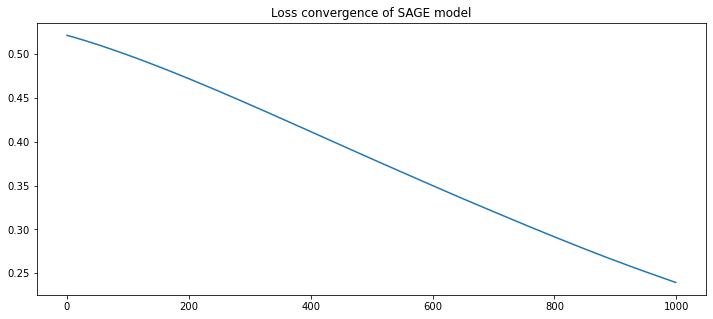



Plot with true labels
---------------------


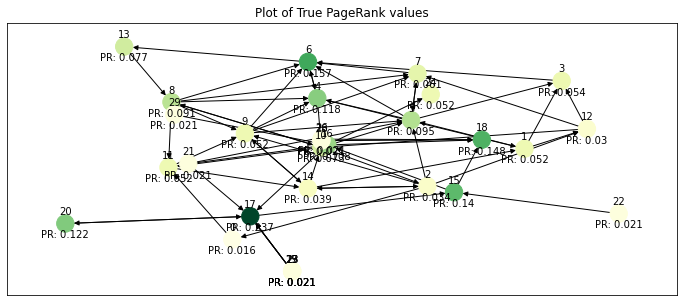

Plot with predicted labels
--------------------------


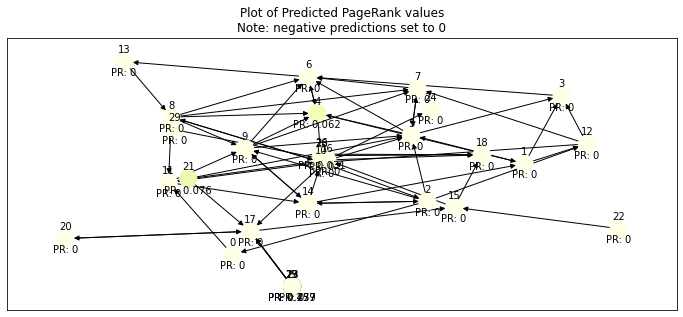

Ground Truth vs. Predictions
--------------------------


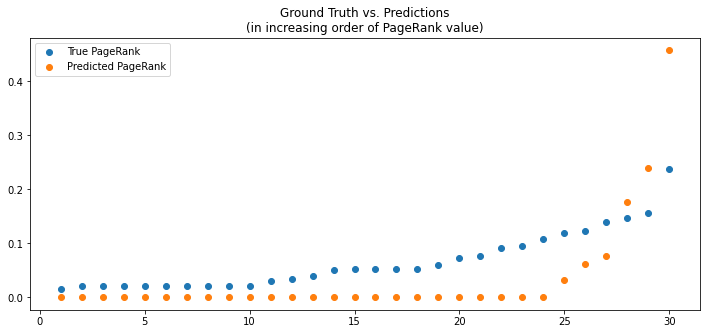

In [81]:
SAGE_model_adadelta_eye.run(print_graph_results=True)

Epoch 0,	loss: 0.376872;		val loss 0.039169
Epoch 50,	loss: 0.174154;		val loss 0.009896
Epoch 100,	loss: 0.115742;		val loss 0.006254
Epoch 150,	loss: 0.084682;		val loss 0.004539
Epoch 200,	loss: 0.064514;		val loss 0.003591
Epoch 250,	loss: 0.050431;		val loss 0.002952
Epoch 300,	loss: 0.040322;		val loss 0.00253
Epoch 350,	loss: 0.032825;		val loss 0.002264
Epoch 400,	loss: 0.027343;		val loss 0.002104
Epoch 450,	loss: 0.023472;		val loss 0.002033
Epoch 500,	loss: 0.02037;		val loss 0.001992
Epoch 550,	loss: 0.017868;		val loss 0.001974
#### VALIDATION LOSS NO IMPROVEMENT IN 10 EPOCHS ####
#### EARLY STOPPING, epoch: 595             ####
Final train loss: 0.016047, validation loss: 0.0019720117561519146.
Test loss: 0.013884


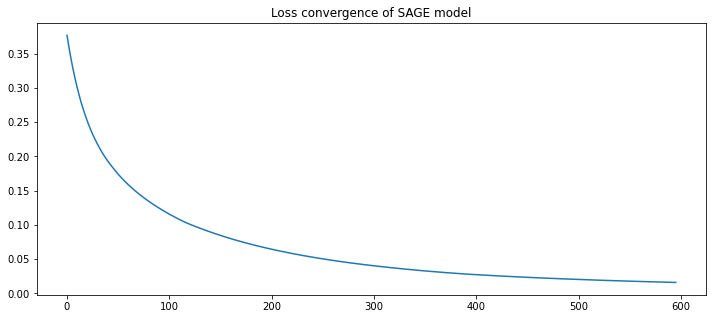



Plot with true labels
---------------------


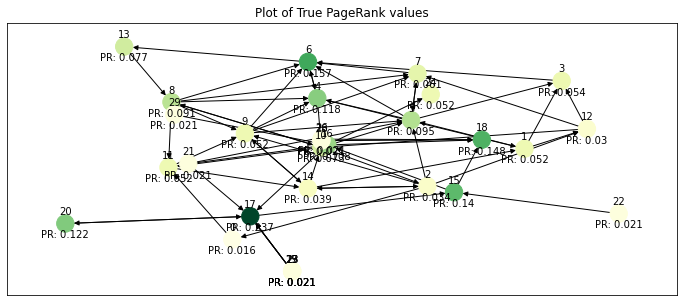

Plot with predicted labels
--------------------------


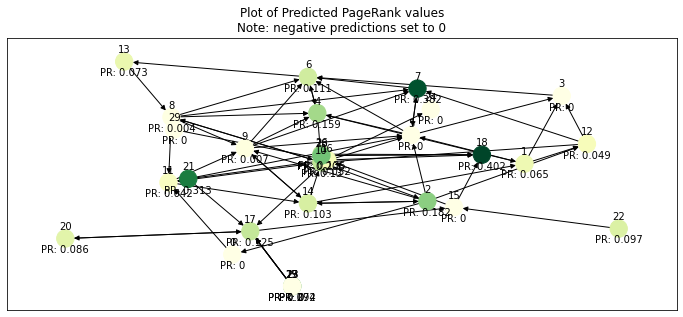

Ground Truth vs. Predictions
--------------------------


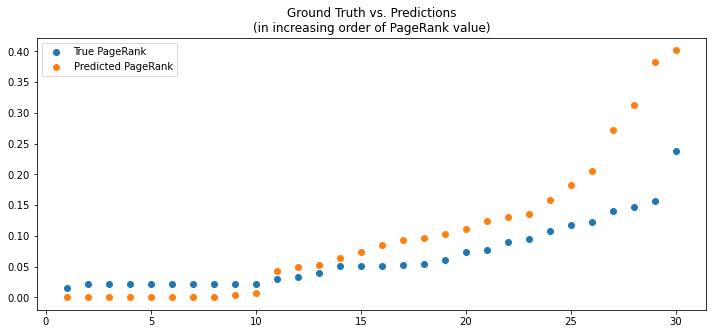

In [82]:
SAGE_model_SGD_eye.run(print_graph_results=True)

## 4. Reproducing the PageRank setup from "The Graph Neural Network Model"

> "A random web graph $\mathcal{G}$ with 5000 nodes and $\delta=0.2$ [*$\delta$ corresponds to the probability to connect two nodes*]. Training, validation, and test sets consisted of different nodes of this graph. More precisely, only 50 nodes were supervised in the training set, other 50 nodes belonged to the validation set, and the remaining nodes were in the test set."

We reduce the number of nodes to 1000 to be able to work on a personal computer. We keep the number of train and validation nodes to 50 respectively.

<u>Note:</u>

Impossible due to memory capacity being insufficient at the time.

## 5. Discussing the Results

Following are the training and validation losses obtained during a run performed on February 20th, 2022. 

<u>Graph Neural Networks with Relaxation</u>
- *Hidden states*: 5
- *Number of epochs*: 1000

| Optimizer | End Training Loss | End Validation Loss | Comment |
| --- | --- | --- | --- |
| Adam | 0.0 | 0.0031 | **OK**, results close to ground truth |
| AdamW | 0.0 | 0.0059 | *NOK*, nodes 1, 2 negative predictions |
| Adamax | 0.0002 | 0.0047 | *NOK*, node 1 negative prediction |
| Adadelta | 0.0083 | 0.0078 | *NOK*, overpredicts nodes 1 to 29, underpredicts 30 |
| SGD | 0.0039 | 0.0013 | *NOK*, underpredicts nodes 26 to 30 |

<u>Graph Convolutional Neural Networks</u>
- *Hidden states*: 5
- *Number of epochs*: 1000

| Feature type | Optimizer | End Training Loss | End Validation Loss | Comment |
| --- | --- | --- | --- | --- |
| Noise | Adam | 0.0014 | 0.0006 | *NOK*, mix of over/under predictions |
| Noise | AdamW | 0.0017 | 0.0003 | *NOK*, mix of over/under predictions |
| Noise | Adamax | 0.001 | 0.0003 | *NOK*, mix of over/under predictions |
| Noise | Adadelta | 0.0053 | 0.0025 | *NOK*, prediction range between 0.0 and 0.05 |
| Noise | SGD | 0.0008 | 0.0002 | *NOK*, mix of over/under predictions |
| Torch Eye | Adam | 0.0 | 0.0001 | **OK**, results close to ground truth |
| Torch Eye | AdamW | 0.0008 | 0.0012 | *NOK*, underpredicts nodes 23 to 28 |
| Torch Eye | Adamax | 0.001 | 0.0008 | *NOK*, underpredicts node 30 |
| Torch Eye | Adadelta | 0.0048 | 0.0006 | *NOK*, overpredicts nodes 14 to 30 |
| Torch Eye | SGD | 0.0008 | 0.0005 | *NOK*, underpredicts node 30 |

<u>SAGE Graph Neural Networks</u>
- *Hidden states*: 5
- *Number of epochs*: 1000

| Feature type | Optimizer | End Training Loss | End Validation Loss | Comment |
| --- | --- | --- | --- | --- |
| Noise | Adam | 0.0216 | 0.0109 | *NOK*, overpredicts nodes 21 to 30 |
| Noise | AdamW | 0.0031 | 0.0011 | *NOK*, mix of over/under predictions |
| Noise | Adamax | 0.0015 | 0.0046 | *NOK*, overpredicts nodes 26 to 30 |
| Noise | Adadelta | 0.0372 | 0.0618 | *NOK*, mix of over/underpredictions |
| Noise | SGD | 0.0102 | 0.0157 | *NOK*, overpredicts nodes 24 to 30 |
| Torch Eye | Adam | 0.0 | 0.0145 | *NOK*, overpredicts nodes 25 to 30 |
| Torch Eye | AdamW | 0.0 | 0.0189 | *NOK*, overpredicts nodes 23 to 30 |
| Torch Eye | Adamax | 0.0555 | 0.049 | *NOK*, mix of over/under predictions |
| Torch Eye | Adadelta | 0.2395 | 0.1058 | *NOK*, mix of over/under predictions |
| Torch Eye | SGD | 0.016 | 0.002 | *NOK*, mix of over/under predictions |